In [1]:
# Input data

import scipy.io as spio
import numpy as np

new_imagery = spio.loadmat(file_name='../data/bci_EEG_data-new/new_imagery.mat')
new_imagery_data = new_imagery['new_imagery']
print(new_imagery_data.shape, new_imagery_data.dtype)

new_imagery_data_transposed = new_imagery_data.transpose(2, 0, 1)
print(new_imagery_data_transposed.shape)

# Deviding the input data into train and validation
# For creating the training and testing set, 30% percent of each subject is considered as test and
# 70% of each subject is conidered as training.
length = int(new_imagery_data_transposed.shape[0] * 0.30)
# length

train_data_all = new_imagery_data_transposed[:-length]
test_data = new_imagery_data_transposed[-length:]

print(new_imagery_data_transposed.shape, new_imagery_data_transposed.dtype, 
 train_data_all.shape, train_data_all.dtype, 
 test_data.shape, test_data.dtype)

# 30% of the total training data is validation,
# 70% of the total training data is training
# This is applied to every single subject data.
length2 = int(train_data_all.shape[0] * 0.30)
# length2

train_data = train_data_all[:-length2]
valid_data = train_data_all[-length2:]

print(train_data_all.shape, train_data_all.dtype, 
 train_data.shape, train_data.dtype, 
 valid_data.shape, valid_data.dtype)

(3584, 13, 1380) float64
(1380, 3584, 13)
(1380, 3584, 13) float64 (966, 3584, 13) float64 (414, 3584, 13) float64
(966, 3584, 13) float64 (677, 3584, 13) float64 (289, 3584, 13) float64


In [2]:
new_imagery_label = spio.loadmat(file_name='../data/bci_EEG_data-new/new_imagery_label.mat')
# print(new_imagery_label.keys())
new_imagery_label_all = new_imagery_label['new_imagery_label']
print(new_imagery_label_all.shape, new_imagery_label_all.dtype)
print(new_imagery_label_all.max(axis=0)+1)

label_train_all = new_imagery_label_all[:-length]
label_test = new_imagery_label_all[-length:]

print(new_imagery_label_all.shape, new_imagery_label_all.dtype,
 label_test.shape, label_test.dtype, 
 label_train_all.shape, label_train_all.dtype)

label_train = label_train_all[:-length2]
label_valid = label_train_all[-length2:]
print(label_train.shape, label_valid.shape)

(1380, 1) uint16
[4]
(1380, 1) uint16 (414, 1) uint16 (966, 1) uint16
(677, 1) (289, 1)


In [3]:
# # Normalizing input data
# def normalize(inputs, inputs_all):
#     return (inputs - inputs_all.mean(axis=0)[None,:,:]) / inputs_all.std(axis=0)[None,:,:]
# Yalda suggested this normalization.
def normalize(inputs):
    return (inputs - inputs.mean(axis=0)[None,:,:]) / inputs.std(axis=0)[None,:,:]

# onehot vectorizing output labels
def one_hot(labels, n_class):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y

# get minibatches for learning
def get_batches(X, y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

# Standardize/normalize train and test
# X_train_norm_all = normalize(inputs=FacesDataTrain, inputs_all=FacesDataAll)
X_train_norm = normalize(inputs=train_data)
X_valid_norm = normalize(inputs=valid_data)
X_test_norm = normalize(inputs=test_data)

print(X_train_norm.shape, X_train_norm.dtype, 
X_valid_norm.shape, X_valid_norm.dtype,
X_test_norm.shape, X_test_norm.dtype)

(677, 3584, 13) float64 (289, 3584, 13) float64 (414, 3584, 13) float64


In [4]:
### Hyperparameters

# Input data
batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial
print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)

# Output labels
n_classes = int(new_imagery_label_all.max(axis=0) + 1)
print('n_classes', n_classes)

# Tweekable parameters
learning_rate = 0.001 #1e-3
epochs = 100 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

batch_size, seq_len, n_channels 6 3584 13
n_classes 4


In [5]:
Y_train = np.array(label_train, dtype=int).reshape(-1)
Y_valid = np.array(label_valid, dtype=int).reshape(-1)
Y_test = np.array(label_test, dtype=int).reshape(-1)

Y_train_onehot = one_hot(labels=Y_train, n_class=n_classes)
Y_valid_onehot = one_hot(labels=Y_valid, n_class=n_classes)
Y_test_onehot = one_hot(labels=Y_test, n_class=n_classes)

print(Y_train_onehot.shape, Y_valid_onehot.shape, Y_test_onehot.shape, 
 X_train_norm.shape, X_valid_norm.shape, X_test_norm.shape)

print(Y_train_onehot.dtype, Y_valid_onehot.dtype, Y_test_onehot.dtype,
 X_train_norm.dtype, X_valid_norm.dtype, X_test_norm.dtype)

(677, 4) (289, 4) (414, 4) (677, 3584, 13) (289, 3584, 13) (414, 3584, 13)
float64 float64 float64 float64 float64 float64


In [6]:
# GPUs or CPU

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

#  No graphs is needed on tensorflow
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')# Construct the LSTM inputs and LSTM cells

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [7]:
# Forward pass: Convolutional Layers, FC Layer, and Output layer
# batch_size, seq_len, n_channels: 6, 3584, 13
# (batch, 3584, 13) --> (batch, 1790, 26)
# (3584 - 6 + 0)/2 + 1 = (3578/2)+1= 1789 +1 = 1790
# 2/6 with strides/kernel_size is 
# 33.333% non-overlap/diff region and 
# 66.666% overlapping window/ common region
in_conv = inputs_
out_conv = tf.layers.conv1d(inputs=in_conv, filters=26, kernel_size=6, strides=2, padding='valid')
out_conv = tf.layers.batch_normalization(inputs=out_conv)
out_conv = tf.nn.relu(features=out_conv)
out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(in_conv.shape, out_conv.shape)

# To reduce the size for memory efficiency & equivariancy/invariency/ minicolumns
# (batch, 1790, 26) --> (batch, 446, 26)
# (1790 - 10 + 0)/4 + 1 = (1780/4)+1= 445 +1 = 446
# 4/10 with strides/kernel_size is 
# 40% non-overlap/diff region and 
# 60% overlapping window/ common region
in_pool = out_conv
out_pool = tf.layers.max_pooling1d(inputs=in_pool, pool_size=10, strides=4, padding='valid')
print(in_pool.shape, out_pool.shape)

# (batch, 446, 26) --> (batch, 221, 52)
# (446 - 6 + 0)/2 + 1 = (440/2)+1= 220+1= 221
# 2/6 with strides/kernel_size is 
# 33.33% non-overlap/diff region and 
# 66.66% overlapping window/ common region
in_conv = out_pool
out_conv = tf.layers.conv1d(inputs=in_conv, filters=52, kernel_size=6, strides=2, padding='valid')
out_conv = tf.layers.batch_normalization(inputs=out_conv)
out_conv = tf.nn.relu(features=out_conv)
out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(in_conv.shape, out_conv.shape)

# To reduce the size for memory efficiency & equivariancy/invariency/ minicolumns
# (batch, 221, 52) --> (batch, 43, 52)
# (221 - 11 + 0)/5 + 1 = (210/5)+1= 42 +1 = 43
# 5/11 with strides/kernel_size is 
# ~45.5% non-overlap/diff region and 
# ~64.5% overlapping window/ common region
in_pool = out_conv
out_pool = tf.layers.max_pooling1d(inputs=in_pool, pool_size=11, strides=5, padding='valid')
print(in_pool.shape, out_pool.shape)

# (batch, 43, 52) --> (batch, 43*52) --> (batch, 43*52*2)
in_fc = tf.reshape(tensor=out_pool, shape=(-1, 43*52))
out_fc = tf.layers.dense(inputs=in_fc, units=43*52*2)
out_fc = tf.layers.batch_normalization(inputs=out_fc)
out_fc = tf.nn.relu(features=out_fc)
out_fc = tf.nn.dropout(x=out_fc, keep_prob=keep_prob_)
print(out_pool.shape, in_fc.shape, out_fc.shape)

# (batch, 43*52*2) --> (batch, 4) 
logits = tf.layers.dense(inputs=out_fc, units=n_classes)
print(out_fc.shape, logits.shape)

(?, 3584, 13) (?, 1790, 26)
(?, 1790, 26) (?, 446, 26)
(?, 446, 26) (?, 221, 52)
(?, 221, 52) (?, 43, 52)
(?, 43, 52) (?, 2236) (?, 4472)
(?, 4472) (?, 4)


In [8]:
# Backward pass: error backpropagation
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [9]:
# Train the network
# Plotting the acc and loss curve
train_acc = []
train_loss = []

valid_acc = []
valid_loss = []

with tf.Session() as sess:
    # initalize session global variables just in the case they are initialized.
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
       
        # Loop over batches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            # Feed dictionary
            feed = {inputs_:x, labels_:y, keep_prob_: keep_prob, learning_rate_:learning_rate}
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            
            train_acc.append(acc)
            train_loss.append(loss)
            
            ################################ Validation
            # Initialize 
            loss_v_batch, acc_v_batch = [], []

            # Loop over batches
            for x_v, y_v in get_batches(X_valid_norm, Y_valid_onehot, batch_size):

                # Feed dictionary
                feed = {inputs_:x_v, labels_:y_v, keep_prob_: 1.0}
                loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)
                
                acc_v_batch.append(acc_v)
                loss_v_batch.append(loss_v)
                
            valid_acc.append(np.mean(acc_v_batch))
            valid_loss.append(np.mean(loss_v_batch))
            
            # Print info
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Train loss: {:6f}".format(loss),
                  "Valid loss: {:.6f}".format(np.mean(valid_loss)),
                  "Train acc: {:6f}".format(acc),
                  "Valid acc: {:.6f}".format(np.mean(valid_acc)))
            
    ################################ Test
    # Initialize 
    acc_batch, loss_batch = [], []

    # Loop over batches
    for x, y in get_batches(X_test_norm, Y_test_onehot, batch_size):

        # Feed dictionary
        feed = {inputs_:x, labels_:y, keep_prob_:1.0}
        loss, acc = sess.run([cost, accuracy], feed_dict = feed)

        acc_batch.append(acc)
        loss_batch.append(loss)

    # Print info
    print("Epoch: {}/{}".format(e+1, epochs),
          "Test loss: {:6f}".format(np.mean(loss_batch)),
          "Test acc: {:6f}".format(np.mean(acc_batch)))

Epoch: 1/100 Train loss: 8.820877 Valid loss: 1.671388 Train acc: 0.000000 Valid acc: 0.319444
Epoch: 1/100 Train loss: 7.835524 Valid loss: 5.791218 Train acc: 0.333333 Valid acc: 0.324653
Epoch: 1/100 Train loss: 30.334070 Valid loss: 7.652388 Train acc: 0.333333 Valid acc: 0.328704
Epoch: 1/100 Train loss: 31.755051 Valid loss: 7.152737 Train acc: 0.333333 Valid acc: 0.330729
Epoch: 1/100 Train loss: 15.825621 Valid loss: 6.058827 Train acc: 0.333333 Valid acc: 0.329861
Epoch: 1/100 Train loss: 5.960955 Valid loss: 5.752361 Train acc: 0.333333 Valid acc: 0.330440
Epoch: 1/100 Train loss: 13.737757 Valid loss: 5.554756 Train acc: 0.333333 Valid acc: 0.330853
Epoch: 1/100 Train loss: 13.034942 Valid loss: 5.192679 Train acc: 0.333333 Valid acc: 0.330295
Epoch: 1/100 Train loss: 8.231338 Valid loss: 4.848593 Train acc: 0.000000 Valid acc: 0.330247
Epoch: 1/100 Train loss: 4.868626 Valid loss: 4.525740 Train acc: 0.333333 Valid acc: 0.330208
Epoch: 1/100 Train loss: 4.978516 Valid loss:

Epoch: 1/100 Train loss: 1.085473 Valid loss: 1.581434 Train acc: 0.666667 Valid acc: 0.320865
Epoch: 1/100 Train loss: 1.063283 Valid loss: 1.576929 Train acc: 0.666667 Valid acc: 0.320927
Epoch: 1/100 Train loss: 1.213264 Valid loss: 1.572501 Train acc: 0.166667 Valid acc: 0.321219
Epoch: 1/100 Train loss: 1.179221 Valid loss: 1.568144 Train acc: 0.333333 Valid acc: 0.321658
Epoch: 1/100 Train loss: 0.979199 Valid loss: 1.563851 Train acc: 0.500000 Valid acc: 0.322049
Epoch: 1/100 Train loss: 1.172499 Valid loss: 1.559624 Train acc: 0.500000 Valid acc: 0.322431
Epoch: 1/100 Train loss: 1.083048 Valid loss: 1.555452 Train acc: 0.666667 Valid acc: 0.322806
Epoch: 1/100 Train loss: 1.228485 Valid loss: 1.551339 Train acc: 0.000000 Valid acc: 0.323246
Epoch: 1/100 Train loss: 1.120873 Valid loss: 1.547285 Train acc: 0.166667 Valid acc: 0.323532
Epoch: 1/100 Train loss: 1.094649 Valid loss: 1.543289 Train acc: 0.500000 Valid acc: 0.323919
Epoch: 1/100 Train loss: 1.153543 Valid loss: 1.53

Epoch: 2/100 Train loss: 1.071843 Valid loss: 1.355782 Train acc: 0.500000 Valid acc: 0.331984
Epoch: 2/100 Train loss: 1.160233 Valid loss: 1.354432 Train acc: 0.166667 Valid acc: 0.332209
Epoch: 2/100 Train loss: 1.137830 Valid loss: 1.353090 Train acc: 0.333333 Valid acc: 0.332372
Epoch: 2/100 Train loss: 1.082343 Valid loss: 1.351758 Train acc: 0.333333 Valid acc: 0.332553
Epoch: 2/100 Train loss: 1.104176 Valid loss: 1.350435 Train acc: 0.333333 Valid acc: 0.332693
Epoch: 2/100 Train loss: 1.184652 Valid loss: 1.349119 Train acc: 0.000000 Valid acc: 0.332832
Epoch: 2/100 Train loss: 1.051682 Valid loss: 1.347813 Train acc: 0.666667 Valid acc: 0.332969
Epoch: 2/100 Train loss: 1.146295 Valid loss: 1.346516 Train acc: 0.166667 Valid acc: 0.333066
Epoch: 2/100 Train loss: 1.141962 Valid loss: 1.345228 Train acc: 0.166667 Valid acc: 0.333163
Epoch: 2/100 Train loss: 1.234397 Valid loss: 1.343951 Train acc: 0.333333 Valid acc: 0.333333
Epoch: 2/100 Train loss: 1.058054 Valid loss: 1.34

Epoch: 3/100 Train loss: 1.076943 Valid loss: 1.272259 Train acc: 0.333333 Valid acc: 0.336462
Epoch: 3/100 Train loss: 1.132773 Valid loss: 1.271647 Train acc: 0.166667 Valid acc: 0.336464
Epoch: 3/100 Train loss: 1.130037 Valid loss: 1.271036 Train acc: 0.333333 Valid acc: 0.336439
Epoch: 3/100 Train loss: 1.113108 Valid loss: 1.270427 Train acc: 0.333333 Valid acc: 0.336414
Epoch: 3/100 Train loss: 1.140635 Valid loss: 1.269819 Train acc: 0.333333 Valid acc: 0.336389
Epoch: 3/100 Train loss: 1.094503 Valid loss: 1.269213 Train acc: 0.500000 Valid acc: 0.336365
Epoch: 3/100 Train loss: 1.036672 Valid loss: 1.268607 Train acc: 0.500000 Valid acc: 0.336341
Epoch: 3/100 Train loss: 1.116687 Valid loss: 1.268004 Train acc: 0.333333 Valid acc: 0.336317
Epoch: 3/100 Train loss: 1.055723 Valid loss: 1.267402 Train acc: 0.500000 Valid acc: 0.336331
Epoch: 3/100 Train loss: 1.058496 Valid loss: 1.266803 Train acc: 0.666667 Valid acc: 0.336359
Epoch: 3/100 Train loss: 1.138564 Valid loss: 1.26

Epoch: 4/100 Train loss: 1.104949 Valid loss: 1.229750 Train acc: 0.333333 Valid acc: 0.337666
Epoch: 4/100 Train loss: 1.108318 Valid loss: 1.229389 Train acc: 0.333333 Valid acc: 0.337654
Epoch: 4/100 Train loss: 1.085974 Valid loss: 1.229029 Train acc: 0.333333 Valid acc: 0.337642
Epoch: 4/100 Train loss: 1.101224 Valid loss: 1.228670 Train acc: 0.333333 Valid acc: 0.337629
Epoch: 4/100 Train loss: 1.100996 Valid loss: 1.228312 Train acc: 0.500000 Valid acc: 0.337617
Epoch: 4/100 Train loss: 1.091351 Valid loss: 1.227955 Train acc: 0.333333 Valid acc: 0.337615
Epoch: 4/100 Train loss: 1.117803 Valid loss: 1.227599 Train acc: 0.333333 Valid acc: 0.337613
Epoch: 4/100 Train loss: 1.081176 Valid loss: 1.227245 Train acc: 0.500000 Valid acc: 0.337611
Epoch: 4/100 Train loss: 1.082678 Valid loss: 1.226893 Train acc: 0.333333 Valid acc: 0.337618
Epoch: 4/100 Train loss: 1.128057 Valid loss: 1.226542 Train acc: 0.166667 Valid acc: 0.337625
Epoch: 4/100 Train loss: 1.035441 Valid loss: 1.22

Epoch: 4/100 Train loss: 1.060841 Valid loss: 1.204149 Train acc: 0.333333 Valid acc: 0.335192
Epoch: 4/100 Train loss: 1.195548 Valid loss: 1.203909 Train acc: 0.000000 Valid acc: 0.335180
Epoch: 4/100 Train loss: 1.053745 Valid loss: 1.203671 Train acc: 0.500000 Valid acc: 0.335168
Epoch: 4/100 Train loss: 1.023740 Valid loss: 1.203434 Train acc: 0.666667 Valid acc: 0.335195
Epoch: 4/100 Train loss: 1.088577 Valid loss: 1.203198 Train acc: 0.666667 Valid acc: 0.335254
Epoch: 4/100 Train loss: 1.075193 Valid loss: 1.202964 Train acc: 0.500000 Valid acc: 0.335296
Epoch: 4/100 Train loss: 1.077101 Valid loss: 1.202730 Train acc: 0.333333 Valid acc: 0.335339
Epoch: 4/100 Train loss: 1.129147 Valid loss: 1.202498 Train acc: 0.166667 Valid acc: 0.335381
Epoch: 4/100 Train loss: 1.142372 Valid loss: 1.202267 Train acc: 0.166667 Valid acc: 0.335415
Epoch: 4/100 Train loss: 1.209099 Valid loss: 1.202037 Train acc: 0.000000 Valid acc: 0.335449
Epoch: 5/100 Train loss: 1.093260 Valid loss: 1.20

Epoch: 5/100 Train loss: 1.100224 Valid loss: 1.186527 Train acc: 0.333333 Valid acc: 0.335850
Epoch: 5/100 Train loss: 1.087886 Valid loss: 1.186359 Train acc: 0.666667 Valid acc: 0.335859
Epoch: 5/100 Train loss: 1.121158 Valid loss: 1.186192 Train acc: 0.000000 Valid acc: 0.335867
Epoch: 5/100 Train loss: 1.102848 Valid loss: 1.186025 Train acc: 0.333333 Valid acc: 0.335875
Epoch: 5/100 Train loss: 1.089722 Valid loss: 1.185859 Train acc: 0.333333 Valid acc: 0.335890
Epoch: 5/100 Train loss: 1.088484 Valid loss: 1.185694 Train acc: 0.333333 Valid acc: 0.335924
Epoch: 5/100 Train loss: 1.111401 Valid loss: 1.185529 Train acc: 0.333333 Valid acc: 0.335959
Epoch: 5/100 Train loss: 1.110642 Valid loss: 1.185365 Train acc: 0.166667 Valid acc: 0.335993
Epoch: 5/100 Train loss: 1.066708 Valid loss: 1.185202 Train acc: 0.666667 Valid acc: 0.335981
Epoch: 5/100 Train loss: 1.134633 Valid loss: 1.185040 Train acc: 0.333333 Valid acc: 0.335983
Epoch: 5/100 Train loss: 1.126826 Valid loss: 1.18

Epoch: 6/100 Train loss: 0.652723 Valid loss: 1.173884 Train acc: 0.833333 Valid acc: 0.336145
Epoch: 6/100 Train loss: 1.037282 Valid loss: 1.173762 Train acc: 0.333333 Valid acc: 0.336129
Epoch: 6/100 Train loss: 1.156882 Valid loss: 1.173641 Train acc: 0.166667 Valid acc: 0.336125
Epoch: 6/100 Train loss: 1.011470 Valid loss: 1.173520 Train acc: 0.166667 Valid acc: 0.336126
Epoch: 6/100 Train loss: 1.071448 Valid loss: 1.173399 Train acc: 0.333333 Valid acc: 0.336132
Epoch: 6/100 Train loss: 1.125615 Valid loss: 1.173278 Train acc: 0.333333 Valid acc: 0.336139
Epoch: 6/100 Train loss: 1.105700 Valid loss: 1.173158 Train acc: 0.166667 Valid acc: 0.336146
Epoch: 6/100 Train loss: 1.128420 Valid loss: 1.173037 Train acc: 0.166667 Valid acc: 0.336152
Epoch: 6/100 Train loss: 1.115754 Valid loss: 1.172917 Train acc: 0.166667 Valid acc: 0.336170
Epoch: 6/100 Train loss: 1.108642 Valid loss: 1.172798 Train acc: 0.333333 Valid acc: 0.336193
Epoch: 6/100 Train loss: 1.082707 Valid loss: 1.17

Epoch: 7/100 Train loss: 1.064135 Valid loss: 1.164558 Train acc: 0.500000 Valid acc: 0.337087
Epoch: 7/100 Train loss: 1.097648 Valid loss: 1.164480 Train acc: 0.333333 Valid acc: 0.337067
Epoch: 7/100 Train loss: 1.228168 Valid loss: 1.164399 Train acc: 0.333333 Valid acc: 0.337062
Epoch: 7/100 Train loss: 1.098007 Valid loss: 1.164317 Train acc: 0.333333 Valid acc: 0.337056
Epoch: 7/100 Train loss: 1.163200 Valid loss: 1.164233 Train acc: 0.333333 Valid acc: 0.337056
Epoch: 7/100 Train loss: 0.976040 Valid loss: 1.164149 Train acc: 0.666667 Valid acc: 0.337061
Epoch: 7/100 Train loss: 1.004128 Valid loss: 1.164066 Train acc: 0.500000 Valid acc: 0.337050
Epoch: 7/100 Train loss: 1.347457 Valid loss: 1.163983 Train acc: 0.000000 Valid acc: 0.337035
Epoch: 7/100 Train loss: 0.964596 Valid loss: 1.163901 Train acc: 0.500000 Valid acc: 0.337011
Epoch: 7/100 Train loss: 1.098379 Valid loss: 1.163820 Train acc: 0.333333 Valid acc: 0.336991
Epoch: 7/100 Train loss: 0.958651 Valid loss: 1.16

Epoch: 8/100 Train loss: 1.156763 Valid loss: 1.158490 Train acc: 0.166667 Valid acc: 0.335897
Epoch: 8/100 Train loss: 1.164686 Valid loss: 1.158422 Train acc: 0.166667 Valid acc: 0.335889
Epoch: 8/100 Train loss: 1.138000 Valid loss: 1.158354 Train acc: 0.333333 Valid acc: 0.335882
Epoch: 8/100 Train loss: 1.086830 Valid loss: 1.158285 Train acc: 0.333333 Valid acc: 0.335874
Epoch: 8/100 Train loss: 1.177851 Valid loss: 1.158215 Train acc: 0.333333 Valid acc: 0.335867
Epoch: 8/100 Train loss: 1.122233 Valid loss: 1.158144 Train acc: 0.166667 Valid acc: 0.335859
Epoch: 8/100 Train loss: 1.085692 Valid loss: 1.158074 Train acc: 0.333333 Valid acc: 0.335851
Epoch: 8/100 Train loss: 1.073029 Valid loss: 1.158003 Train acc: 0.000000 Valid acc: 0.335848
Epoch: 8/100 Train loss: 1.083211 Valid loss: 1.157931 Train acc: 0.500000 Valid acc: 0.335849
Epoch: 8/100 Train loss: 1.109781 Valid loss: 1.157860 Train acc: 0.333333 Valid acc: 0.335859
Epoch: 8/100 Train loss: 1.100551 Valid loss: 1.15

Epoch: 8/100 Train loss: 1.077253 Valid loss: 1.152699 Train acc: 0.833333 Valid acc: 0.335459
Epoch: 8/100 Train loss: 1.083868 Valid loss: 1.152639 Train acc: 0.500000 Valid acc: 0.335460
Epoch: 8/100 Train loss: 1.119248 Valid loss: 1.152580 Train acc: 0.333333 Valid acc: 0.335462
Epoch: 8/100 Train loss: 1.088468 Valid loss: 1.152521 Train acc: 0.333333 Valid acc: 0.335463
Epoch: 8/100 Train loss: 1.060486 Valid loss: 1.152463 Train acc: 0.500000 Valid acc: 0.335465
Epoch: 8/100 Train loss: 1.079635 Valid loss: 1.152404 Train acc: 0.333333 Valid acc: 0.335462
Epoch: 8/100 Train loss: 1.124170 Valid loss: 1.152346 Train acc: 0.166667 Valid acc: 0.335452
Epoch: 8/100 Train loss: 1.040884 Valid loss: 1.152287 Train acc: 0.500000 Valid acc: 0.335442
Epoch: 8/100 Train loss: 1.078436 Valid loss: 1.152228 Train acc: 0.333333 Valid acc: 0.335428
Epoch: 8/100 Train loss: 1.097753 Valid loss: 1.152170 Train acc: 0.333333 Valid acc: 0.335406
Epoch: 8/100 Train loss: 1.037098 Valid loss: 1.15

Epoch: 9/100 Train loss: 1.092195 Valid loss: 1.148258 Train acc: 0.333333 Valid acc: 0.334906
Epoch: 9/100 Train loss: 1.125121 Valid loss: 1.148214 Train acc: 0.333333 Valid acc: 0.334901
Epoch: 9/100 Train loss: 1.108306 Valid loss: 1.148170 Train acc: 0.500000 Valid acc: 0.334896
Epoch: 9/100 Train loss: 1.112046 Valid loss: 1.148126 Train acc: 0.333333 Valid acc: 0.334890
Epoch: 9/100 Train loss: 1.077768 Valid loss: 1.148080 Train acc: 0.666667 Valid acc: 0.334885
Epoch: 9/100 Train loss: 1.122954 Valid loss: 1.148034 Train acc: 0.166667 Valid acc: 0.334880
Epoch: 9/100 Train loss: 1.039552 Valid loss: 1.147988 Train acc: 0.500000 Valid acc: 0.334871
Epoch: 9/100 Train loss: 1.120231 Valid loss: 1.147941 Train acc: 0.166667 Valid acc: 0.334863
Epoch: 9/100 Train loss: 1.187663 Valid loss: 1.147894 Train acc: 0.000000 Valid acc: 0.334854
Epoch: 9/100 Train loss: 1.073886 Valid loss: 1.147846 Train acc: 0.666667 Valid acc: 0.334845
Epoch: 9/100 Train loss: 1.063898 Valid loss: 1.14

Epoch: 10/100 Train loss: 0.957758 Valid loss: 1.144391 Train acc: 0.666667 Valid acc: 0.334504
Epoch: 10/100 Train loss: 1.072964 Valid loss: 1.144349 Train acc: 0.333333 Valid acc: 0.334496
Epoch: 10/100 Train loss: 1.103551 Valid loss: 1.144308 Train acc: 0.166667 Valid acc: 0.334485
Epoch: 10/100 Train loss: 1.117531 Valid loss: 1.144267 Train acc: 0.666667 Valid acc: 0.334468
Epoch: 10/100 Train loss: 1.288752 Valid loss: 1.144228 Train acc: 0.000000 Valid acc: 0.334450
Epoch: 10/100 Train loss: 1.043295 Valid loss: 1.144188 Train acc: 0.500000 Valid acc: 0.334443
Epoch: 10/100 Train loss: 0.719366 Valid loss: 1.144150 Train acc: 0.500000 Valid acc: 0.334422
Epoch: 10/100 Train loss: 1.151771 Valid loss: 1.144111 Train acc: 0.000000 Valid acc: 0.334404
Epoch: 10/100 Train loss: 1.050497 Valid loss: 1.144074 Train acc: 0.166667 Valid acc: 0.334387
Epoch: 10/100 Train loss: 0.970527 Valid loss: 1.144036 Train acc: 0.833333 Valid acc: 0.334363
Epoch: 10/100 Train loss: 0.806156 Valid

Epoch: 11/100 Train loss: 1.113414 Valid loss: 1.141072 Train acc: 0.333333 Valid acc: 0.334031
Epoch: 11/100 Train loss: 1.096430 Valid loss: 1.141035 Train acc: 0.333333 Valid acc: 0.334043
Epoch: 11/100 Train loss: 1.115344 Valid loss: 1.140998 Train acc: 0.166667 Valid acc: 0.334055
Epoch: 11/100 Train loss: 1.100778 Valid loss: 1.140961 Train acc: 0.166667 Valid acc: 0.334066
Epoch: 11/100 Train loss: 1.122198 Valid loss: 1.140925 Train acc: 0.166667 Valid acc: 0.334078
Epoch: 11/100 Train loss: 1.148197 Valid loss: 1.140888 Train acc: 0.500000 Valid acc: 0.334089
Epoch: 11/100 Train loss: 1.061696 Valid loss: 1.140851 Train acc: 0.500000 Valid acc: 0.334101
Epoch: 11/100 Train loss: 1.047855 Valid loss: 1.140815 Train acc: 0.500000 Valid acc: 0.334106
Epoch: 11/100 Train loss: 1.138155 Valid loss: 1.140778 Train acc: 0.333333 Valid acc: 0.334111
Epoch: 11/100 Train loss: 1.111086 Valid loss: 1.140742 Train acc: 0.333333 Valid acc: 0.334117
Epoch: 11/100 Train loss: 1.105832 Valid

Epoch: 11/100 Train loss: 1.044315 Valid loss: 1.138779 Train acc: 0.666667 Valid acc: 0.334143
Epoch: 11/100 Train loss: 1.089338 Valid loss: 1.138745 Train acc: 0.333333 Valid acc: 0.334146
Epoch: 11/100 Train loss: 1.096521 Valid loss: 1.138711 Train acc: 0.500000 Valid acc: 0.334148
Epoch: 11/100 Train loss: 1.155571 Valid loss: 1.138676 Train acc: 0.000000 Valid acc: 0.334150
Epoch: 11/100 Train loss: 1.056024 Valid loss: 1.138641 Train acc: 0.500000 Valid acc: 0.334149
Epoch: 11/100 Train loss: 1.097769 Valid loss: 1.138606 Train acc: 0.166667 Valid acc: 0.334154
Epoch: 11/100 Train loss: 1.114985 Valid loss: 1.138572 Train acc: 0.166667 Valid acc: 0.334162
Epoch: 12/100 Train loss: 1.103158 Valid loss: 1.138537 Train acc: 0.166667 Valid acc: 0.334170
Epoch: 12/100 Train loss: 1.147702 Valid loss: 1.138502 Train acc: 0.000000 Valid acc: 0.334177
Epoch: 12/100 Train loss: 1.345081 Valid loss: 1.138467 Train acc: 0.166667 Valid acc: 0.334185
Epoch: 12/100 Train loss: 1.063576 Valid

Epoch: 12/100 Train loss: 1.083134 Valid loss: 1.136087 Train acc: 0.166667 Valid acc: 0.334442
Epoch: 12/100 Train loss: 1.079105 Valid loss: 1.136058 Train acc: 0.333333 Valid acc: 0.334444
Epoch: 12/100 Train loss: 1.090370 Valid loss: 1.136029 Train acc: 0.500000 Valid acc: 0.334443
Epoch: 12/100 Train loss: 1.082448 Valid loss: 1.136000 Train acc: 0.500000 Valid acc: 0.334437
Epoch: 12/100 Train loss: 0.918014 Valid loss: 1.135973 Train acc: 0.833333 Valid acc: 0.334434
Epoch: 12/100 Train loss: 1.111493 Valid loss: 1.135947 Train acc: 0.166667 Valid acc: 0.334441
Epoch: 12/100 Train loss: 1.285191 Valid loss: 1.135920 Train acc: 0.166667 Valid acc: 0.334411
Epoch: 12/100 Train loss: 0.954891 Valid loss: 1.135895 Train acc: 0.166667 Valid acc: 0.334389
Epoch: 12/100 Train loss: 0.910910 Valid loss: 1.135872 Train acc: 0.500000 Valid acc: 0.334372
Epoch: 12/100 Train loss: 1.058187 Valid loss: 1.135851 Train acc: 0.500000 Valid acc: 0.334351
Epoch: 12/100 Train loss: 1.151139 Valid

Epoch: 13/100 Train loss: 0.859480 Valid loss: 1.133828 Train acc: 0.666667 Valid acc: 0.334096
Epoch: 13/100 Train loss: 0.358582 Valid loss: 1.133801 Train acc: 0.833333 Valid acc: 0.334090
Epoch: 13/100 Train loss: 1.076108 Valid loss: 1.133774 Train acc: 0.666667 Valid acc: 0.334087
Epoch: 13/100 Train loss: 0.541265 Valid loss: 1.133748 Train acc: 0.833333 Valid acc: 0.334084
Epoch: 13/100 Train loss: 0.610980 Valid loss: 1.133721 Train acc: 0.666667 Valid acc: 0.334081
Epoch: 13/100 Train loss: 0.893043 Valid loss: 1.133695 Train acc: 0.500000 Valid acc: 0.334078
Epoch: 13/100 Train loss: 0.566035 Valid loss: 1.133668 Train acc: 0.666667 Valid acc: 0.334075
Epoch: 13/100 Train loss: 1.125631 Valid loss: 1.133642 Train acc: 0.166667 Valid acc: 0.334070
Epoch: 13/100 Train loss: 1.047687 Valid loss: 1.133617 Train acc: 0.166667 Valid acc: 0.334069
Epoch: 13/100 Train loss: 1.086551 Valid loss: 1.133592 Train acc: 0.500000 Valid acc: 0.334066
Epoch: 13/100 Train loss: 1.132101 Valid

Epoch: 14/100 Train loss: 1.168927 Valid loss: 1.131741 Train acc: 0.333333 Valid acc: 0.334040
Epoch: 14/100 Train loss: 1.086735 Valid loss: 1.131717 Train acc: 0.666667 Valid acc: 0.334044
Epoch: 14/100 Train loss: 1.148813 Valid loss: 1.131693 Train acc: 0.166667 Valid acc: 0.334048
Epoch: 14/100 Train loss: 1.087358 Valid loss: 1.131669 Train acc: 0.500000 Valid acc: 0.334053
Epoch: 14/100 Train loss: 1.118631 Valid loss: 1.131645 Train acc: 0.333333 Valid acc: 0.334057
Epoch: 14/100 Train loss: 1.045793 Valid loss: 1.131621 Train acc: 0.500000 Valid acc: 0.334061
Epoch: 14/100 Train loss: 1.062302 Valid loss: 1.131597 Train acc: 0.333333 Valid acc: 0.334065
Epoch: 14/100 Train loss: 1.104266 Valid loss: 1.131573 Train acc: 0.166667 Valid acc: 0.334069
Epoch: 14/100 Train loss: 1.074053 Valid loss: 1.131549 Train acc: 0.333333 Valid acc: 0.334073
Epoch: 14/100 Train loss: 1.104107 Valid loss: 1.131525 Train acc: 0.166667 Valid acc: 0.334078
Epoch: 14/100 Train loss: 1.155087 Valid

Epoch: 15/100 Train loss: 1.042599 Valid loss: 1.129842 Train acc: 0.333333 Valid acc: 0.334147
Epoch: 15/100 Train loss: 1.097499 Valid loss: 1.129820 Train acc: 0.333333 Valid acc: 0.334151
Epoch: 15/100 Train loss: 1.087822 Valid loss: 1.129798 Train acc: 0.500000 Valid acc: 0.334155
Epoch: 15/100 Train loss: 0.952610 Valid loss: 1.129776 Train acc: 0.833333 Valid acc: 0.334159
Epoch: 15/100 Train loss: 1.182714 Valid loss: 1.129754 Train acc: 0.000000 Valid acc: 0.334163
Epoch: 15/100 Train loss: 1.075212 Valid loss: 1.129732 Train acc: 0.166667 Valid acc: 0.334167
Epoch: 15/100 Train loss: 1.138030 Valid loss: 1.129710 Train acc: 0.000000 Valid acc: 0.334171
Epoch: 15/100 Train loss: 1.180023 Valid loss: 1.129689 Train acc: 0.000000 Valid acc: 0.334177
Epoch: 15/100 Train loss: 1.128613 Valid loss: 1.129667 Train acc: 0.000000 Valid acc: 0.334185
Epoch: 15/100 Train loss: 1.091251 Valid loss: 1.129645 Train acc: 0.166667 Valid acc: 0.334191
Epoch: 15/100 Train loss: 1.078707 Valid

Epoch: 15/100 Train loss: 1.093197 Valid loss: 1.128090 Train acc: 0.333333 Valid acc: 0.334222
Epoch: 15/100 Train loss: 1.034574 Valid loss: 1.128071 Train acc: 0.333333 Valid acc: 0.334220
Epoch: 15/100 Train loss: 1.124686 Valid loss: 1.128052 Train acc: 0.166667 Valid acc: 0.334217
Epoch: 15/100 Train loss: 1.103484 Valid loss: 1.128033 Train acc: 0.500000 Valid acc: 0.334214
Epoch: 15/100 Train loss: 1.099437 Valid loss: 1.128014 Train acc: 0.333333 Valid acc: 0.334212
Epoch: 15/100 Train loss: 1.133272 Valid loss: 1.127996 Train acc: 0.166667 Valid acc: 0.334209
Epoch: 15/100 Train loss: 1.095609 Valid loss: 1.127977 Train acc: 0.333333 Valid acc: 0.334207
Epoch: 15/100 Train loss: 1.112995 Valid loss: 1.127958 Train acc: 0.166667 Valid acc: 0.334204
Epoch: 15/100 Train loss: 1.111540 Valid loss: 1.127939 Train acc: 0.333333 Valid acc: 0.334201
Epoch: 15/100 Train loss: 1.131719 Valid loss: 1.127920 Train acc: 0.166667 Valid acc: 0.334199
Epoch: 15/100 Train loss: 1.140179 Valid

Epoch: 16/100 Train loss: 1.086575 Valid loss: 1.126532 Train acc: 0.500000 Valid acc: 0.334222
Epoch: 16/100 Train loss: 1.075126 Valid loss: 1.126516 Train acc: 0.333333 Valid acc: 0.334222
Epoch: 16/100 Train loss: 1.081867 Valid loss: 1.126501 Train acc: 0.500000 Valid acc: 0.334221
Epoch: 16/100 Train loss: 1.172280 Valid loss: 1.126486 Train acc: 0.166667 Valid acc: 0.334221
Epoch: 16/100 Train loss: 1.156092 Valid loss: 1.126472 Train acc: 0.166667 Valid acc: 0.334220
Epoch: 16/100 Train loss: 1.137229 Valid loss: 1.126457 Train acc: 0.333333 Valid acc: 0.334220
Epoch: 16/100 Train loss: 1.090139 Valid loss: 1.126442 Train acc: 0.166667 Valid acc: 0.334219
Epoch: 16/100 Train loss: 0.902208 Valid loss: 1.126427 Train acc: 0.500000 Valid acc: 0.334219
Epoch: 16/100 Train loss: 1.111877 Valid loss: 1.126412 Train acc: 0.000000 Valid acc: 0.334218
Epoch: 16/100 Train loss: 1.084875 Valid loss: 1.126396 Train acc: 0.333333 Valid acc: 0.334218
Epoch: 16/100 Train loss: 0.961551 Valid

Epoch: 17/100 Train loss: 1.128695 Valid loss: 1.125092 Train acc: 0.333333 Valid acc: 0.334350
Epoch: 17/100 Train loss: 1.012705 Valid loss: 1.125076 Train acc: 0.833333 Valid acc: 0.334353
Epoch: 17/100 Train loss: 1.108766 Valid loss: 1.125060 Train acc: 0.166667 Valid acc: 0.334356
Epoch: 17/100 Train loss: 1.097298 Valid loss: 1.125045 Train acc: 0.333333 Valid acc: 0.334359
Epoch: 17/100 Train loss: 1.172035 Valid loss: 1.125029 Train acc: 0.000000 Valid acc: 0.334363
Epoch: 17/100 Train loss: 1.136882 Valid loss: 1.125013 Train acc: 0.333333 Valid acc: 0.334366
Epoch: 17/100 Train loss: 1.099878 Valid loss: 1.124997 Train acc: 0.500000 Valid acc: 0.334369
Epoch: 17/100 Train loss: 1.053837 Valid loss: 1.124982 Train acc: 0.333333 Valid acc: 0.334372
Epoch: 17/100 Train loss: 1.023245 Valid loss: 1.124966 Train acc: 0.500000 Valid acc: 0.334375
Epoch: 17/100 Train loss: 1.166105 Valid loss: 1.124951 Train acc: 0.333333 Valid acc: 0.334379
Epoch: 17/100 Train loss: 1.087525 Valid

Epoch: 18/100 Train loss: 1.133095 Valid loss: 1.123819 Train acc: 0.333333 Valid acc: 0.334289
Epoch: 18/100 Train loss: 1.103709 Valid loss: 1.123805 Train acc: 0.166667 Valid acc: 0.334289
Epoch: 18/100 Train loss: 1.115113 Valid loss: 1.123790 Train acc: 0.166667 Valid acc: 0.334288
Epoch: 18/100 Train loss: 1.034869 Valid loss: 1.123776 Train acc: 0.500000 Valid acc: 0.334288
Epoch: 18/100 Train loss: 1.027344 Valid loss: 1.123762 Train acc: 0.666667 Valid acc: 0.334287
Epoch: 18/100 Train loss: 1.047965 Valid loss: 1.123748 Train acc: 0.166667 Valid acc: 0.334287
Epoch: 18/100 Train loss: 1.072702 Valid loss: 1.123734 Train acc: 0.166667 Valid acc: 0.334286
Epoch: 18/100 Train loss: 1.127236 Valid loss: 1.123719 Train acc: 0.166667 Valid acc: 0.334288
Epoch: 18/100 Train loss: 1.094835 Valid loss: 1.123705 Train acc: 0.500000 Valid acc: 0.334287
Epoch: 18/100 Train loss: 1.079581 Valid loss: 1.123691 Train acc: 0.500000 Valid acc: 0.334287
Epoch: 18/100 Train loss: 1.123881 Valid

Epoch: 18/100 Train loss: 1.075742 Valid loss: 1.122793 Train acc: 0.666667 Valid acc: 0.334295
Epoch: 18/100 Train loss: 1.110351 Valid loss: 1.122779 Train acc: 0.333333 Valid acc: 0.334298
Epoch: 18/100 Train loss: 1.145868 Valid loss: 1.122766 Train acc: 0.333333 Valid acc: 0.334301
Epoch: 18/100 Train loss: 1.097663 Valid loss: 1.122753 Train acc: 0.166667 Valid acc: 0.334304
Epoch: 18/100 Train loss: 1.109397 Valid loss: 1.122739 Train acc: 0.333333 Valid acc: 0.334307
Epoch: 18/100 Train loss: 1.059056 Valid loss: 1.122726 Train acc: 0.666667 Valid acc: 0.334310
Epoch: 18/100 Train loss: 1.140040 Valid loss: 1.122712 Train acc: 0.166667 Valid acc: 0.334313
Epoch: 18/100 Train loss: 1.118348 Valid loss: 1.122699 Train acc: 0.333333 Valid acc: 0.334318
Epoch: 18/100 Train loss: 1.116972 Valid loss: 1.122686 Train acc: 0.333333 Valid acc: 0.334321
Epoch: 18/100 Train loss: 1.129748 Valid loss: 1.122673 Train acc: 0.166667 Valid acc: 0.334322
Epoch: 18/100 Train loss: 1.058347 Valid

Epoch: 19/100 Train loss: 1.095004 Valid loss: 1.121764 Train acc: 0.333333 Valid acc: 0.334364
Epoch: 19/100 Train loss: 1.062435 Valid loss: 1.121754 Train acc: 0.333333 Valid acc: 0.334367
Epoch: 19/100 Train loss: 1.096600 Valid loss: 1.121743 Train acc: 0.333333 Valid acc: 0.334369
Epoch: 19/100 Train loss: 1.201055 Valid loss: 1.121732 Train acc: 0.166667 Valid acc: 0.334372
Epoch: 19/100 Train loss: 1.058645 Valid loss: 1.121720 Train acc: 0.333333 Valid acc: 0.334375
Epoch: 19/100 Train loss: 1.113294 Valid loss: 1.121708 Train acc: 0.166667 Valid acc: 0.334378
Epoch: 19/100 Train loss: 1.104416 Valid loss: 1.121697 Train acc: 0.333333 Valid acc: 0.334381
Epoch: 19/100 Train loss: 1.040346 Valid loss: 1.121685 Train acc: 0.333333 Valid acc: 0.334383
Epoch: 19/100 Train loss: 1.091110 Valid loss: 1.121673 Train acc: 0.500000 Valid acc: 0.334385
Epoch: 19/100 Train loss: 1.154589 Valid loss: 1.121661 Train acc: 0.166667 Valid acc: 0.334386
Epoch: 19/100 Train loss: 1.151610 Valid

Epoch: 20/100 Train loss: 1.157987 Valid loss: 1.120803 Train acc: 0.333333 Valid acc: 0.334409
Epoch: 20/100 Train loss: 1.097681 Valid loss: 1.120791 Train acc: 0.166667 Valid acc: 0.334409
Epoch: 20/100 Train loss: 1.114030 Valid loss: 1.120780 Train acc: 0.166667 Valid acc: 0.334408
Epoch: 20/100 Train loss: 1.141754 Valid loss: 1.120768 Train acc: 0.166667 Valid acc: 0.334408
Epoch: 20/100 Train loss: 1.051171 Valid loss: 1.120757 Train acc: 0.500000 Valid acc: 0.334407
Epoch: 20/100 Train loss: 1.111804 Valid loss: 1.120746 Train acc: 0.333333 Valid acc: 0.334407
Epoch: 20/100 Train loss: 1.119391 Valid loss: 1.120734 Train acc: 0.333333 Valid acc: 0.334406
Epoch: 20/100 Train loss: 0.852705 Valid loss: 1.120723 Train acc: 0.500000 Valid acc: 0.334404
Epoch: 20/100 Train loss: 0.825407 Valid loss: 1.120712 Train acc: 0.666667 Valid acc: 0.334402
Epoch: 20/100 Train loss: 0.984844 Valid loss: 1.120700 Train acc: 0.333333 Valid acc: 0.334400
Epoch: 20/100 Train loss: 0.654483 Valid

Epoch: 21/100 Train loss: 1.055529 Valid loss: 1.119827 Train acc: 0.333333 Valid acc: 0.334396
Epoch: 21/100 Train loss: 1.108948 Valid loss: 1.119816 Train acc: 0.500000 Valid acc: 0.334395
Epoch: 21/100 Train loss: 1.184792 Valid loss: 1.119805 Train acc: 0.000000 Valid acc: 0.334392
Epoch: 21/100 Train loss: 1.098405 Valid loss: 1.119794 Train acc: 0.500000 Valid acc: 0.334388
Epoch: 21/100 Train loss: 1.141659 Valid loss: 1.119782 Train acc: 0.333333 Valid acc: 0.334386
Epoch: 21/100 Train loss: 0.980075 Valid loss: 1.119771 Train acc: 0.500000 Valid acc: 0.334372
Epoch: 21/100 Train loss: 1.138375 Valid loss: 1.119760 Train acc: 0.166667 Valid acc: 0.334366
Epoch: 21/100 Train loss: 1.127399 Valid loss: 1.119749 Train acc: 0.333333 Valid acc: 0.334359
Epoch: 21/100 Train loss: 1.010199 Valid loss: 1.119738 Train acc: 0.666667 Valid acc: 0.334352
Epoch: 21/100 Train loss: 1.032248 Valid loss: 1.119726 Train acc: 0.333333 Valid acc: 0.334350
Epoch: 21/100 Train loss: 0.921954 Valid

Epoch: 21/100 Train loss: 1.131028 Valid loss: 1.118950 Train acc: 0.333333 Valid acc: 0.334385
Epoch: 21/100 Train loss: 1.135006 Valid loss: 1.118940 Train acc: 0.166667 Valid acc: 0.334391
Epoch: 21/100 Train loss: 1.130516 Valid loss: 1.118931 Train acc: 0.166667 Valid acc: 0.334396
Epoch: 21/100 Train loss: 1.096994 Valid loss: 1.118921 Train acc: 0.500000 Valid acc: 0.334402
Epoch: 21/100 Train loss: 1.068253 Valid loss: 1.118912 Train acc: 0.333333 Valid acc: 0.334407
Epoch: 21/100 Train loss: 1.216457 Valid loss: 1.118903 Train acc: 0.166667 Valid acc: 0.334411
Epoch: 21/100 Train loss: 1.112610 Valid loss: 1.118893 Train acc: 0.333333 Valid acc: 0.334415
Epoch: 21/100 Train loss: 1.108787 Valid loss: 1.118884 Train acc: 0.333333 Valid acc: 0.334420
Epoch: 21/100 Train loss: 1.086827 Valid loss: 1.118875 Train acc: 0.500000 Valid acc: 0.334423
Epoch: 22/100 Train loss: 1.144478 Valid loss: 1.118865 Train acc: 0.333333 Valid acc: 0.334427
Epoch: 22/100 Train loss: 1.162085 Valid

Epoch: 22/100 Train loss: 1.117456 Valid loss: 1.118118 Train acc: 0.333333 Valid acc: 0.334446
Epoch: 22/100 Train loss: 1.033693 Valid loss: 1.118110 Train acc: 0.500000 Valid acc: 0.334444
Epoch: 22/100 Train loss: 0.995590 Valid loss: 1.118101 Train acc: 0.833333 Valid acc: 0.334442
Epoch: 22/100 Train loss: 1.123120 Valid loss: 1.118093 Train acc: 0.166667 Valid acc: 0.334440
Epoch: 22/100 Train loss: 1.130029 Valid loss: 1.118084 Train acc: 0.333333 Valid acc: 0.334438
Epoch: 22/100 Train loss: 1.145188 Valid loss: 1.118076 Train acc: 0.166667 Valid acc: 0.334437
Epoch: 22/100 Train loss: 1.132628 Valid loss: 1.118068 Train acc: 0.166667 Valid acc: 0.334435
Epoch: 22/100 Train loss: 1.129033 Valid loss: 1.118060 Train acc: 0.333333 Valid acc: 0.334433
Epoch: 22/100 Train loss: 1.157494 Valid loss: 1.118052 Train acc: 0.000000 Valid acc: 0.334431
Epoch: 22/100 Train loss: 1.076568 Valid loss: 1.118044 Train acc: 0.666667 Valid acc: 0.334429
Epoch: 22/100 Train loss: 1.079194 Valid

Epoch: 23/100 Train loss: 1.233098 Valid loss: 1.117412 Train acc: 0.000000 Valid acc: 0.334460
Epoch: 23/100 Train loss: 0.635481 Valid loss: 1.117404 Train acc: 0.666667 Valid acc: 0.334463
Epoch: 23/100 Train loss: 0.462360 Valid loss: 1.117396 Train acc: 0.833333 Valid acc: 0.334465
Epoch: 23/100 Train loss: 2.945932 Valid loss: 1.117388 Train acc: 0.500000 Valid acc: 0.334467
Epoch: 23/100 Train loss: 0.481716 Valid loss: 1.117381 Train acc: 0.833333 Valid acc: 0.334470
Epoch: 23/100 Train loss: 1.171283 Valid loss: 1.117375 Train acc: 0.333333 Valid acc: 0.334472
Epoch: 23/100 Train loss: 1.191847 Valid loss: 1.117371 Train acc: 0.666667 Valid acc: 0.334474
Epoch: 23/100 Train loss: 0.681357 Valid loss: 1.117369 Train acc: 0.500000 Valid acc: 0.334471
Epoch: 23/100 Train loss: 1.242386 Valid loss: 1.117370 Train acc: 0.000000 Valid acc: 0.334468
Epoch: 23/100 Train loss: 1.160420 Valid loss: 1.117373 Train acc: 0.166667 Valid acc: 0.334465
Epoch: 23/100 Train loss: 1.187545 Valid

Epoch: 24/100 Train loss: 1.195026 Valid loss: 1.116994 Train acc: 0.333333 Valid acc: 0.334334
Epoch: 24/100 Train loss: 1.100808 Valid loss: 1.116987 Train acc: 0.333333 Valid acc: 0.334333
Epoch: 24/100 Train loss: 1.045602 Valid loss: 1.116979 Train acc: 0.500000 Valid acc: 0.334333
Epoch: 24/100 Train loss: 1.132070 Valid loss: 1.116972 Train acc: 0.166667 Valid acc: 0.334333
Epoch: 24/100 Train loss: 1.177784 Valid loss: 1.116964 Train acc: 0.333333 Valid acc: 0.334332
Epoch: 24/100 Train loss: 1.102050 Valid loss: 1.116955 Train acc: 0.333333 Valid acc: 0.334332
Epoch: 24/100 Train loss: 1.105910 Valid loss: 1.116947 Train acc: 0.333333 Valid acc: 0.334331
Epoch: 24/100 Train loss: 1.139196 Valid loss: 1.116939 Train acc: 0.333333 Valid acc: 0.334331
Epoch: 24/100 Train loss: 1.102536 Valid loss: 1.116930 Train acc: 0.500000 Valid acc: 0.334331
Epoch: 24/100 Train loss: 1.105692 Valid loss: 1.116922 Train acc: 0.166667 Valid acc: 0.334330
Epoch: 24/100 Train loss: 1.156247 Valid

Epoch: 25/100 Train loss: 1.115846 Valid loss: 1.116373 Train acc: 0.333333 Valid acc: 0.334375
Epoch: 25/100 Train loss: 1.206563 Valid loss: 1.116365 Train acc: 0.000000 Valid acc: 0.334375
Epoch: 25/100 Train loss: 1.150163 Valid loss: 1.116358 Train acc: 0.333333 Valid acc: 0.334375
Epoch: 25/100 Train loss: 1.108841 Valid loss: 1.116350 Train acc: 0.333333 Valid acc: 0.334374
Epoch: 25/100 Train loss: 1.075602 Valid loss: 1.116342 Train acc: 0.166667 Valid acc: 0.334374
Epoch: 25/100 Train loss: 1.155528 Valid loss: 1.116334 Train acc: 0.500000 Valid acc: 0.334373
Epoch: 25/100 Train loss: 1.148246 Valid loss: 1.116327 Train acc: 0.166667 Valid acc: 0.334373
Epoch: 25/100 Train loss: 1.040824 Valid loss: 1.116319 Train acc: 0.500000 Valid acc: 0.334373
Epoch: 25/100 Train loss: 1.138801 Valid loss: 1.116311 Train acc: 0.166667 Valid acc: 0.334372
Epoch: 25/100 Train loss: 1.137127 Valid loss: 1.116303 Train acc: 0.500000 Valid acc: 0.334372
Epoch: 25/100 Train loss: 1.107197 Valid

Epoch: 25/100 Train loss: 1.082083 Valid loss: 1.115720 Train acc: 0.333333 Valid acc: 0.334351
Epoch: 25/100 Train loss: 1.073636 Valid loss: 1.115713 Train acc: 0.333333 Valid acc: 0.334348
Epoch: 25/100 Train loss: 1.107286 Valid loss: 1.115705 Train acc: 0.166667 Valid acc: 0.334345
Epoch: 25/100 Train loss: 1.168528 Valid loss: 1.115698 Train acc: 0.000000 Valid acc: 0.334342
Epoch: 25/100 Train loss: 0.987612 Valid loss: 1.115691 Train acc: 0.666667 Valid acc: 0.334339
Epoch: 25/100 Train loss: 1.074119 Valid loss: 1.115683 Train acc: 0.333333 Valid acc: 0.334336
Epoch: 25/100 Train loss: 1.096231 Valid loss: 1.115676 Train acc: 0.500000 Valid acc: 0.334333
Epoch: 25/100 Train loss: 1.116154 Valid loss: 1.115669 Train acc: 0.166667 Valid acc: 0.334337
Epoch: 25/100 Train loss: 1.114100 Valid loss: 1.115662 Train acc: 0.333333 Valid acc: 0.334339
Epoch: 25/100 Train loss: 1.072876 Valid loss: 1.115655 Train acc: 0.333333 Valid acc: 0.334341
Epoch: 25/100 Train loss: 1.089404 Valid

Epoch: 26/100 Train loss: 1.074181 Valid loss: 1.115118 Train acc: 0.333333 Valid acc: 0.334387
Epoch: 26/100 Train loss: 1.098895 Valid loss: 1.115112 Train acc: 0.166667 Valid acc: 0.334389
Epoch: 26/100 Train loss: 1.156460 Valid loss: 1.115106 Train acc: 0.333333 Valid acc: 0.334391
Epoch: 26/100 Train loss: 1.114789 Valid loss: 1.115100 Train acc: 0.333333 Valid acc: 0.334393
Epoch: 26/100 Train loss: 1.124091 Valid loss: 1.115094 Train acc: 0.333333 Valid acc: 0.334393
Epoch: 26/100 Train loss: 1.103767 Valid loss: 1.115088 Train acc: 0.333333 Valid acc: 0.334392
Epoch: 26/100 Train loss: 1.163550 Valid loss: 1.115081 Train acc: 0.000000 Valid acc: 0.334392
Epoch: 26/100 Train loss: 1.087771 Valid loss: 1.115075 Train acc: 0.500000 Valid acc: 0.334391
Epoch: 26/100 Train loss: 0.977910 Valid loss: 1.115068 Train acc: 0.333333 Valid acc: 0.334391
Epoch: 26/100 Train loss: 1.053165 Valid loss: 1.115062 Train acc: 0.500000 Valid acc: 0.334392
Epoch: 26/100 Train loss: 1.017721 Valid

Epoch: 27/100 Train loss: 1.063906 Valid loss: 1.114738 Train acc: 0.333333 Valid acc: 0.334481
Epoch: 27/100 Train loss: 1.121969 Valid loss: 1.114732 Train acc: 0.333333 Valid acc: 0.334479
Epoch: 27/100 Train loss: 1.098112 Valid loss: 1.114726 Train acc: 0.500000 Valid acc: 0.334478
Epoch: 27/100 Train loss: 1.149542 Valid loss: 1.114720 Train acc: 0.000000 Valid acc: 0.334476
Epoch: 27/100 Train loss: 1.145908 Valid loss: 1.114714 Train acc: 0.166667 Valid acc: 0.334475
Epoch: 27/100 Train loss: 1.009542 Valid loss: 1.114708 Train acc: 0.666667 Valid acc: 0.334473
Epoch: 27/100 Train loss: 1.063421 Valid loss: 1.114702 Train acc: 0.166667 Valid acc: 0.334472
Epoch: 27/100 Train loss: 1.224187 Valid loss: 1.114696 Train acc: 0.333333 Valid acc: 0.334470
Epoch: 27/100 Train loss: 1.130382 Valid loss: 1.114690 Train acc: 0.333333 Valid acc: 0.334468
Epoch: 27/100 Train loss: 1.021850 Valid loss: 1.114683 Train acc: 0.333333 Valid acc: 0.334468
Epoch: 27/100 Train loss: 1.004035 Valid

Epoch: 28/100 Train loss: 1.017212 Valid loss: 1.114197 Train acc: 0.666667 Valid acc: 0.334541
Epoch: 28/100 Train loss: 1.069058 Valid loss: 1.114191 Train acc: 0.333333 Valid acc: 0.334540
Epoch: 28/100 Train loss: 1.114697 Valid loss: 1.114184 Train acc: 0.333333 Valid acc: 0.334538
Epoch: 28/100 Train loss: 1.051047 Valid loss: 1.114178 Train acc: 0.333333 Valid acc: 0.334536
Epoch: 28/100 Train loss: 1.122735 Valid loss: 1.114172 Train acc: 0.333333 Valid acc: 0.334538
Epoch: 28/100 Train loss: 1.094484 Valid loss: 1.114165 Train acc: 0.166667 Valid acc: 0.334540
Epoch: 28/100 Train loss: 0.999205 Valid loss: 1.114159 Train acc: 0.666667 Valid acc: 0.334542
Epoch: 28/100 Train loss: 1.079852 Valid loss: 1.114153 Train acc: 0.500000 Valid acc: 0.334544
Epoch: 28/100 Train loss: 1.050786 Valid loss: 1.114147 Train acc: 0.500000 Valid acc: 0.334546
Epoch: 28/100 Train loss: 1.117609 Valid loss: 1.114140 Train acc: 0.166667 Valid acc: 0.334548
Epoch: 28/100 Train loss: 1.184208 Valid

Epoch: 28/100 Train loss: 1.075373 Valid loss: 1.113696 Train acc: 0.166667 Valid acc: 0.334609
Epoch: 28/100 Train loss: 1.130460 Valid loss: 1.113691 Train acc: 0.333333 Valid acc: 0.334609
Epoch: 28/100 Train loss: 1.205179 Valid loss: 1.113685 Train acc: 0.333333 Valid acc: 0.334608
Epoch: 28/100 Train loss: 1.151712 Valid loss: 1.113680 Train acc: 0.333333 Valid acc: 0.334608
Epoch: 28/100 Train loss: 1.152868 Valid loss: 1.113675 Train acc: 0.000000 Valid acc: 0.334607
Epoch: 28/100 Train loss: 1.072641 Valid loss: 1.113669 Train acc: 0.500000 Valid acc: 0.334607
Epoch: 28/100 Train loss: 1.189515 Valid loss: 1.113664 Train acc: 0.166667 Valid acc: 0.334607
Epoch: 28/100 Train loss: 1.093896 Valid loss: 1.113659 Train acc: 0.333333 Valid acc: 0.334606
Epoch: 28/100 Train loss: 1.057644 Valid loss: 1.113653 Train acc: 0.500000 Valid acc: 0.334606
Epoch: 28/100 Train loss: 1.076840 Valid loss: 1.113648 Train acc: 0.166667 Valid acc: 0.334605
Epoch: 28/100 Train loss: 1.117584 Valid

Epoch: 29/100 Train loss: 1.002567 Valid loss: 1.113220 Train acc: 0.666667 Valid acc: 0.334680
Epoch: 29/100 Train loss: 1.160906 Valid loss: 1.113215 Train acc: 0.000000 Valid acc: 0.334678
Epoch: 29/100 Train loss: 1.166075 Valid loss: 1.113210 Train acc: 0.000000 Valid acc: 0.334678
Epoch: 29/100 Train loss: 1.143461 Valid loss: 1.113205 Train acc: 0.000000 Valid acc: 0.334677
Epoch: 29/100 Train loss: 1.117670 Valid loss: 1.113199 Train acc: 0.333333 Valid acc: 0.334677
Epoch: 29/100 Train loss: 1.173999 Valid loss: 1.113194 Train acc: 0.166667 Valid acc: 0.334676
Epoch: 29/100 Train loss: 1.124655 Valid loss: 1.113189 Train acc: 0.500000 Valid acc: 0.334676
Epoch: 29/100 Train loss: 1.095517 Valid loss: 1.113183 Train acc: 0.333333 Valid acc: 0.334676
Epoch: 29/100 Train loss: 1.055111 Valid loss: 1.113178 Train acc: 0.500000 Valid acc: 0.334675
Epoch: 29/100 Train loss: 0.996578 Valid loss: 1.113173 Train acc: 0.500000 Valid acc: 0.334675
Epoch: 29/100 Train loss: 1.044631 Valid

Epoch: 30/100 Train loss: 1.137542 Valid loss: 1.112753 Train acc: 0.000000 Valid acc: 0.334631
Epoch: 30/100 Train loss: 1.018606 Valid loss: 1.112748 Train acc: 0.500000 Valid acc: 0.334632
Epoch: 30/100 Train loss: 1.151654 Valid loss: 1.112742 Train acc: 0.333333 Valid acc: 0.334634
Epoch: 30/100 Train loss: 1.118616 Valid loss: 1.112737 Train acc: 0.500000 Valid acc: 0.334636
Epoch: 30/100 Train loss: 1.161124 Valid loss: 1.112731 Train acc: 0.166667 Valid acc: 0.334637
Epoch: 30/100 Train loss: 1.094609 Valid loss: 1.112726 Train acc: 0.333333 Valid acc: 0.334639
Epoch: 30/100 Train loss: 1.027727 Valid loss: 1.112721 Train acc: 0.666667 Valid acc: 0.334641
Epoch: 30/100 Train loss: 0.743343 Valid loss: 1.112715 Train acc: 0.333333 Valid acc: 0.334643
Epoch: 30/100 Train loss: 0.704410 Valid loss: 1.112710 Train acc: 0.666667 Valid acc: 0.334644
Epoch: 30/100 Train loss: 1.056461 Valid loss: 1.112705 Train acc: 0.500000 Valid acc: 0.334646
Epoch: 30/100 Train loss: 0.769587 Valid

Epoch: 31/100 Train loss: 1.161968 Valid loss: 1.112332 Train acc: 0.166667 Valid acc: 0.334688
Epoch: 31/100 Train loss: 1.085855 Valid loss: 1.112326 Train acc: 0.500000 Valid acc: 0.334688
Epoch: 31/100 Train loss: 1.117758 Valid loss: 1.112321 Train acc: 0.333333 Valid acc: 0.334687
Epoch: 31/100 Train loss: 1.124618 Valid loss: 1.112316 Train acc: 0.333333 Valid acc: 0.334687
Epoch: 31/100 Train loss: 1.048066 Valid loss: 1.112311 Train acc: 0.666667 Valid acc: 0.334686
Epoch: 31/100 Train loss: 1.190154 Valid loss: 1.112306 Train acc: 0.333333 Valid acc: 0.334686
Epoch: 31/100 Train loss: 0.907874 Valid loss: 1.112301 Train acc: 0.833333 Valid acc: 0.334686
Epoch: 31/100 Train loss: 1.064090 Valid loss: 1.112296 Train acc: 0.500000 Valid acc: 0.334685
Epoch: 31/100 Train loss: 1.171461 Valid loss: 1.112291 Train acc: 0.166667 Valid acc: 0.334685
Epoch: 31/100 Train loss: 1.109044 Valid loss: 1.112286 Train acc: 0.166667 Valid acc: 0.334684
Epoch: 31/100 Train loss: 1.072916 Valid

Epoch: 31/100 Train loss: 1.090797 Valid loss: 1.112002 Train acc: 0.166667 Valid acc: 0.334666
Epoch: 31/100 Train loss: 1.011968 Valid loss: 1.111998 Train acc: 0.333333 Valid acc: 0.334666
Epoch: 31/100 Train loss: 1.114695 Valid loss: 1.111993 Train acc: 0.333333 Valid acc: 0.334666
Epoch: 31/100 Train loss: 1.042355 Valid loss: 1.111989 Train acc: 0.500000 Valid acc: 0.334665
Epoch: 31/100 Train loss: 1.013121 Valid loss: 1.111984 Train acc: 0.500000 Valid acc: 0.334665
Epoch: 31/100 Train loss: 1.006533 Valid loss: 1.111979 Train acc: 0.666667 Valid acc: 0.334667
Epoch: 31/100 Train loss: 1.114733 Valid loss: 1.111975 Train acc: 0.166667 Valid acc: 0.334668
Epoch: 31/100 Train loss: 1.088208 Valid loss: 1.111970 Train acc: 0.166667 Valid acc: 0.334670
Epoch: 31/100 Train loss: 1.231751 Valid loss: 1.111966 Train acc: 0.333333 Valid acc: 0.334671
Epoch: 32/100 Train loss: 1.027006 Valid loss: 1.111961 Train acc: 0.666667 Valid acc: 0.334673
Epoch: 32/100 Train loss: 1.291847 Valid

Epoch: 32/100 Train loss: 0.890458 Valid loss: 1.111631 Train acc: 0.500000 Valid acc: 0.334760
Epoch: 32/100 Train loss: 1.196551 Valid loss: 1.111629 Train acc: 0.166667 Valid acc: 0.334762
Epoch: 32/100 Train loss: 1.148201 Valid loss: 1.111627 Train acc: 0.000000 Valid acc: 0.334764
Epoch: 32/100 Train loss: 1.112415 Valid loss: 1.111626 Train acc: 0.333333 Valid acc: 0.334768
Epoch: 32/100 Train loss: 1.224888 Valid loss: 1.111624 Train acc: 0.166667 Valid acc: 0.334767
Epoch: 32/100 Train loss: 1.185399 Valid loss: 1.111624 Train acc: 0.000000 Valid acc: 0.334766
Epoch: 32/100 Train loss: 1.112803 Valid loss: 1.111623 Train acc: 0.333333 Valid acc: 0.334765
Epoch: 32/100 Train loss: 1.145678 Valid loss: 1.111623 Train acc: 0.000000 Valid acc: 0.334766
Epoch: 32/100 Train loss: 1.077090 Valid loss: 1.111623 Train acc: 0.166667 Valid acc: 0.334771
Epoch: 32/100 Train loss: 1.089801 Valid loss: 1.111624 Train acc: 0.333333 Valid acc: 0.334776
Epoch: 32/100 Train loss: 1.067557 Valid

Epoch: 33/100 Train loss: 0.945266 Valid loss: 1.111882 Train acc: 0.333333 Valid acc: 0.334899
Epoch: 33/100 Train loss: 1.147260 Valid loss: 1.111877 Train acc: 0.166667 Valid acc: 0.334898
Epoch: 33/100 Train loss: 0.851283 Valid loss: 1.111873 Train acc: 0.500000 Valid acc: 0.334900
Epoch: 33/100 Train loss: 0.197645 Valid loss: 1.111868 Train acc: 0.833333 Valid acc: 0.334901
Epoch: 33/100 Train loss: 0.345537 Valid loss: 1.111864 Train acc: 1.000000 Valid acc: 0.334903
Epoch: 33/100 Train loss: 0.816425 Valid loss: 1.111860 Train acc: 0.333333 Valid acc: 0.334904
Epoch: 33/100 Train loss: 0.877353 Valid loss: 1.111856 Train acc: 0.333333 Valid acc: 0.334906
Epoch: 33/100 Train loss: 0.647231 Valid loss: 1.111851 Train acc: 0.833333 Valid acc: 0.334907
Epoch: 33/100 Train loss: 0.723181 Valid loss: 1.111848 Train acc: 0.666667 Valid acc: 0.334908
Epoch: 33/100 Train loss: 1.096372 Valid loss: 1.111844 Train acc: 0.333333 Valid acc: 0.334910
Epoch: 33/100 Train loss: 1.146522 Valid

Epoch: 34/100 Train loss: 1.136743 Valid loss: 1.111497 Train acc: 0.166667 Valid acc: 0.334970
Epoch: 34/100 Train loss: 1.178023 Valid loss: 1.111492 Train acc: 0.333333 Valid acc: 0.334970
Epoch: 34/100 Train loss: 1.160835 Valid loss: 1.111488 Train acc: 0.166667 Valid acc: 0.334971
Epoch: 34/100 Train loss: 1.074043 Valid loss: 1.111483 Train acc: 0.333333 Valid acc: 0.334971
Epoch: 34/100 Train loss: 1.135064 Valid loss: 1.111478 Train acc: 0.166667 Valid acc: 0.334972
Epoch: 34/100 Train loss: 1.186311 Valid loss: 1.111473 Train acc: 0.000000 Valid acc: 0.334972
Epoch: 34/100 Train loss: 1.142864 Valid loss: 1.111469 Train acc: 0.333333 Valid acc: 0.334973
Epoch: 34/100 Train loss: 1.063045 Valid loss: 1.111464 Train acc: 0.500000 Valid acc: 0.334975
Epoch: 34/100 Train loss: 1.060785 Valid loss: 1.111459 Train acc: 0.500000 Valid acc: 0.334977
Epoch: 34/100 Train loss: 1.111934 Valid loss: 1.111454 Train acc: 0.333333 Valid acc: 0.334980
Epoch: 34/100 Train loss: 1.272491 Valid

Epoch: 34/100 Train loss: 1.145592 Valid loss: 1.111106 Train acc: 0.333333 Valid acc: 0.335060
Epoch: 35/100 Train loss: 1.016535 Valid loss: 1.111101 Train acc: 0.500000 Valid acc: 0.335063
Epoch: 35/100 Train loss: 1.075304 Valid loss: 1.111096 Train acc: 0.500000 Valid acc: 0.335065
Epoch: 35/100 Train loss: 1.142093 Valid loss: 1.111091 Train acc: 0.333333 Valid acc: 0.335067
Epoch: 35/100 Train loss: 1.070518 Valid loss: 1.111086 Train acc: 0.500000 Valid acc: 0.335069
Epoch: 35/100 Train loss: 1.131270 Valid loss: 1.111081 Train acc: 0.333333 Valid acc: 0.335072
Epoch: 35/100 Train loss: 1.041612 Valid loss: 1.111077 Train acc: 0.500000 Valid acc: 0.335074
Epoch: 35/100 Train loss: 1.006624 Valid loss: 1.111072 Train acc: 0.500000 Valid acc: 0.335076
Epoch: 35/100 Train loss: 1.186121 Valid loss: 1.111067 Train acc: 0.333333 Valid acc: 0.335079
Epoch: 35/100 Train loss: 1.136667 Valid loss: 1.111062 Train acc: 0.333333 Valid acc: 0.335081
Epoch: 35/100 Train loss: 1.181380 Valid

Epoch: 35/100 Train loss: 1.129201 Valid loss: 1.110739 Train acc: 0.166667 Valid acc: 0.335076
Epoch: 35/100 Train loss: 1.049677 Valid loss: 1.110735 Train acc: 0.333333 Valid acc: 0.335073
Epoch: 35/100 Train loss: 1.086688 Valid loss: 1.110732 Train acc: 0.500000 Valid acc: 0.335073
Epoch: 35/100 Train loss: 1.120888 Valid loss: 1.110729 Train acc: 0.166667 Valid acc: 0.335073
Epoch: 35/100 Train loss: 1.119463 Valid loss: 1.110725 Train acc: 0.333333 Valid acc: 0.335072
Epoch: 35/100 Train loss: 1.214020 Valid loss: 1.110721 Train acc: 0.333333 Valid acc: 0.335072
Epoch: 35/100 Train loss: 1.048294 Valid loss: 1.110718 Train acc: 0.333333 Valid acc: 0.335071
Epoch: 35/100 Train loss: 1.131891 Valid loss: 1.110715 Train acc: 0.166667 Valid acc: 0.335071
Epoch: 35/100 Train loss: 1.184349 Valid loss: 1.110711 Train acc: 0.166667 Valid acc: 0.335070
Epoch: 35/100 Train loss: 1.174050 Valid loss: 1.110707 Train acc: 0.166667 Valid acc: 0.335070
Epoch: 35/100 Train loss: 1.122065 Valid

Epoch: 36/100 Train loss: 0.724163 Valid loss: 1.110412 Train acc: 0.666667 Valid acc: 0.335025
Epoch: 36/100 Train loss: 1.177719 Valid loss: 1.110410 Train acc: 0.333333 Valid acc: 0.335025
Epoch: 36/100 Train loss: 1.101604 Valid loss: 1.110408 Train acc: 0.166667 Valid acc: 0.335024
Epoch: 36/100 Train loss: 1.158610 Valid loss: 1.110406 Train acc: 0.333333 Valid acc: 0.335024
Epoch: 36/100 Train loss: 1.222292 Valid loss: 1.110405 Train acc: 0.000000 Valid acc: 0.335023
Epoch: 36/100 Train loss: 1.168483 Valid loss: 1.110403 Train acc: 0.166667 Valid acc: 0.335023
Epoch: 36/100 Train loss: 1.163049 Valid loss: 1.110402 Train acc: 0.166667 Valid acc: 0.335022
Epoch: 36/100 Train loss: 1.061272 Valid loss: 1.110401 Train acc: 0.333333 Valid acc: 0.335022
Epoch: 36/100 Train loss: 1.189446 Valid loss: 1.110399 Train acc: 0.500000 Valid acc: 0.335023
Epoch: 36/100 Train loss: 1.237808 Valid loss: 1.110397 Train acc: 0.000000 Valid acc: 0.335023
Epoch: 36/100 Train loss: 1.100205 Valid

Epoch: 37/100 Train loss: 1.136266 Valid loss: 1.110156 Train acc: 0.500000 Valid acc: 0.335041
Epoch: 37/100 Train loss: 1.180476 Valid loss: 1.110152 Train acc: 0.000000 Valid acc: 0.335043
Epoch: 37/100 Train loss: 0.931933 Valid loss: 1.110149 Train acc: 0.500000 Valid acc: 0.335044
Epoch: 37/100 Train loss: 1.180184 Valid loss: 1.110146 Train acc: 0.000000 Valid acc: 0.335045
Epoch: 37/100 Train loss: 1.112960 Valid loss: 1.110142 Train acc: 0.333333 Valid acc: 0.335046
Epoch: 37/100 Train loss: 1.158115 Valid loss: 1.110139 Train acc: 0.000000 Valid acc: 0.335048
Epoch: 37/100 Train loss: 1.167544 Valid loss: 1.110135 Train acc: 0.333333 Valid acc: 0.335049
Epoch: 37/100 Train loss: 0.921329 Valid loss: 1.110132 Train acc: 0.333333 Valid acc: 0.335050
Epoch: 37/100 Train loss: 1.071345 Valid loss: 1.110129 Train acc: 0.500000 Valid acc: 0.335052
Epoch: 37/100 Train loss: 1.108838 Valid loss: 1.110125 Train acc: 0.666667 Valid acc: 0.335053
Epoch: 37/100 Train loss: 1.008032 Valid

Epoch: 38/100 Train loss: 1.165276 Valid loss: 1.109856 Train acc: 0.333333 Valid acc: 0.335054
Epoch: 38/100 Train loss: 1.173779 Valid loss: 1.109852 Train acc: 0.333333 Valid acc: 0.335055
Epoch: 38/100 Train loss: 1.183108 Valid loss: 1.109848 Train acc: 0.000000 Valid acc: 0.335055
Epoch: 38/100 Train loss: 1.156564 Valid loss: 1.109845 Train acc: 0.333333 Valid acc: 0.335056
Epoch: 38/100 Train loss: 1.049103 Valid loss: 1.109841 Train acc: 0.500000 Valid acc: 0.335056
Epoch: 38/100 Train loss: 1.223752 Valid loss: 1.109837 Train acc: 0.166667 Valid acc: 0.335056
Epoch: 38/100 Train loss: 1.093817 Valid loss: 1.109834 Train acc: 0.166667 Valid acc: 0.335057
Epoch: 38/100 Train loss: 1.090112 Valid loss: 1.109830 Train acc: 0.500000 Valid acc: 0.335057
Epoch: 38/100 Train loss: 1.098182 Valid loss: 1.109826 Train acc: 0.333333 Valid acc: 0.335058
Epoch: 38/100 Train loss: 1.115148 Valid loss: 1.109823 Train acc: 0.500000 Valid acc: 0.335058
Epoch: 38/100 Train loss: 1.099319 Valid

Epoch: 38/100 Train loss: 1.093873 Valid loss: 1.109616 Train acc: 0.166667 Valid acc: 0.335145
Epoch: 38/100 Train loss: 1.114767 Valid loss: 1.109613 Train acc: 0.333333 Valid acc: 0.335144
Epoch: 38/100 Train loss: 1.180607 Valid loss: 1.109609 Train acc: 0.166667 Valid acc: 0.335144
Epoch: 38/100 Train loss: 1.058367 Valid loss: 1.109606 Train acc: 0.333333 Valid acc: 0.335144
Epoch: 38/100 Train loss: 1.029043 Valid loss: 1.109603 Train acc: 0.666667 Valid acc: 0.335143
Epoch: 38/100 Train loss: 1.014313 Valid loss: 1.109600 Train acc: 0.500000 Valid acc: 0.335143
Epoch: 38/100 Train loss: 0.980086 Valid loss: 1.109597 Train acc: 0.666667 Valid acc: 0.335142
Epoch: 38/100 Train loss: 1.073241 Valid loss: 1.109594 Train acc: 0.500000 Valid acc: 0.335142
Epoch: 38/100 Train loss: 1.208543 Valid loss: 1.109591 Train acc: 0.166667 Valid acc: 0.335141
Epoch: 38/100 Train loss: 1.173463 Valid loss: 1.109588 Train acc: 0.166667 Valid acc: 0.335141
Epoch: 38/100 Train loss: 1.031354 Valid

Epoch: 39/100 Train loss: 1.193062 Valid loss: 1.109346 Train acc: 0.500000 Valid acc: 0.335160
Epoch: 39/100 Train loss: 0.824808 Valid loss: 1.109343 Train acc: 0.833333 Valid acc: 0.335161
Epoch: 39/100 Train loss: 1.204384 Valid loss: 1.109340 Train acc: 0.166667 Valid acc: 0.335163
Epoch: 39/100 Train loss: 1.059936 Valid loss: 1.109337 Train acc: 0.666667 Valid acc: 0.335164
Epoch: 39/100 Train loss: 1.179494 Valid loss: 1.109334 Train acc: 0.333333 Valid acc: 0.335165
Epoch: 39/100 Train loss: 1.169491 Valid loss: 1.109331 Train acc: 0.333333 Valid acc: 0.335166
Epoch: 39/100 Train loss: 1.224914 Valid loss: 1.109327 Train acc: 0.000000 Valid acc: 0.335167
Epoch: 39/100 Train loss: 1.107540 Valid loss: 1.109324 Train acc: 0.333333 Valid acc: 0.335168
Epoch: 39/100 Train loss: 1.099216 Valid loss: 1.109320 Train acc: 0.166667 Valid acc: 0.335168
Epoch: 39/100 Train loss: 1.158175 Valid loss: 1.109317 Train acc: 0.333333 Valid acc: 0.335168
Epoch: 39/100 Train loss: 1.002465 Valid

Epoch: 40/100 Train loss: 1.077383 Valid loss: 1.109062 Train acc: 0.333333 Valid acc: 0.335202
Epoch: 40/100 Train loss: 1.127549 Valid loss: 1.109058 Train acc: 0.333333 Valid acc: 0.335202
Epoch: 40/100 Train loss: 1.182219 Valid loss: 1.109055 Train acc: 0.166667 Valid acc: 0.335202
Epoch: 40/100 Train loss: 1.142991 Valid loss: 1.109051 Train acc: 0.333333 Valid acc: 0.335203
Epoch: 40/100 Train loss: 1.172000 Valid loss: 1.109048 Train acc: 0.333333 Valid acc: 0.335203
Epoch: 40/100 Train loss: 1.082225 Valid loss: 1.109045 Train acc: 0.500000 Valid acc: 0.335204
Epoch: 40/100 Train loss: 1.012912 Valid loss: 1.109042 Train acc: 0.500000 Valid acc: 0.335204
Epoch: 40/100 Train loss: 1.185200 Valid loss: 1.109038 Train acc: 0.166667 Valid acc: 0.335203
Epoch: 40/100 Train loss: 1.110415 Valid loss: 1.109035 Train acc: 0.166667 Valid acc: 0.335203
Epoch: 40/100 Train loss: 0.490961 Valid loss: 1.109031 Train acc: 1.000000 Valid acc: 0.335203
Epoch: 40/100 Train loss: 1.038539 Valid

Epoch: 41/100 Train loss: 1.145646 Valid loss: 1.108778 Train acc: 0.000000 Valid acc: 0.335262
Epoch: 41/100 Train loss: 1.151524 Valid loss: 1.108774 Train acc: 0.166667 Valid acc: 0.335262
Epoch: 41/100 Train loss: 1.141334 Valid loss: 1.108771 Train acc: 0.166667 Valid acc: 0.335262
Epoch: 41/100 Train loss: 1.108866 Valid loss: 1.108767 Train acc: 0.333333 Valid acc: 0.335263
Epoch: 41/100 Train loss: 1.065287 Valid loss: 1.108764 Train acc: 0.500000 Valid acc: 0.335263
Epoch: 41/100 Train loss: 1.169536 Valid loss: 1.108761 Train acc: 0.333333 Valid acc: 0.335263
Epoch: 41/100 Train loss: 1.071616 Valid loss: 1.108758 Train acc: 0.666667 Valid acc: 0.335264
Epoch: 41/100 Train loss: 1.158034 Valid loss: 1.108754 Train acc: 0.333333 Valid acc: 0.335264
Epoch: 41/100 Train loss: 0.924750 Valid loss: 1.108751 Train acc: 0.500000 Valid acc: 0.335264
Epoch: 41/100 Train loss: 1.152949 Valid loss: 1.108748 Train acc: 0.166667 Valid acc: 0.335265
Epoch: 41/100 Train loss: 1.116915 Valid

Epoch: 41/100 Train loss: 1.163329 Valid loss: 1.108532 Train acc: 0.166667 Valid acc: 0.335305
Epoch: 41/100 Train loss: 1.264317 Valid loss: 1.108529 Train acc: 0.166667 Valid acc: 0.335306
Epoch: 41/100 Train loss: 1.022413 Valid loss: 1.108526 Train acc: 0.500000 Valid acc: 0.335307
Epoch: 41/100 Train loss: 1.207379 Valid loss: 1.108523 Train acc: 0.166667 Valid acc: 0.335308
Epoch: 41/100 Train loss: 1.153051 Valid loss: 1.108520 Train acc: 0.000000 Valid acc: 0.335309
Epoch: 41/100 Train loss: 1.089879 Valid loss: 1.108517 Train acc: 0.333333 Valid acc: 0.335311
Epoch: 41/100 Train loss: 1.081311 Valid loss: 1.108514 Train acc: 0.500000 Valid acc: 0.335312
Epoch: 41/100 Train loss: 1.097948 Valid loss: 1.108511 Train acc: 0.500000 Valid acc: 0.335313
Epoch: 41/100 Train loss: 1.037201 Valid loss: 1.108508 Train acc: 0.666667 Valid acc: 0.335314
Epoch: 41/100 Train loss: 1.065392 Valid loss: 1.108505 Train acc: 0.333333 Valid acc: 0.335315
Epoch: 41/100 Train loss: 1.048790 Valid

Epoch: 42/100 Train loss: 1.111217 Valid loss: 1.108294 Train acc: 0.166667 Valid acc: 0.335379
Epoch: 42/100 Train loss: 1.026976 Valid loss: 1.108291 Train acc: 0.500000 Valid acc: 0.335378
Epoch: 42/100 Train loss: 1.181170 Valid loss: 1.108288 Train acc: 0.333333 Valid acc: 0.335378
Epoch: 42/100 Train loss: 1.169118 Valid loss: 1.108285 Train acc: 0.166667 Valid acc: 0.335378
Epoch: 42/100 Train loss: 1.059548 Valid loss: 1.108283 Train acc: 0.666667 Valid acc: 0.335377
Epoch: 42/100 Train loss: 1.095589 Valid loss: 1.108280 Train acc: 0.500000 Valid acc: 0.335377
Epoch: 42/100 Train loss: 1.154514 Valid loss: 1.108277 Train acc: 0.500000 Valid acc: 0.335376
Epoch: 42/100 Train loss: 1.089971 Valid loss: 1.108274 Train acc: 0.500000 Valid acc: 0.335376
Epoch: 42/100 Train loss: 1.174295 Valid loss: 1.108271 Train acc: 0.333333 Valid acc: 0.335375
Epoch: 42/100 Train loss: 1.113373 Valid loss: 1.108268 Train acc: 0.166667 Valid acc: 0.335375
Epoch: 42/100 Train loss: 0.989099 Valid

Epoch: 43/100 Train loss: 1.163383 Valid loss: 1.108054 Train acc: 0.166667 Valid acc: 0.335386
Epoch: 43/100 Train loss: 0.697743 Valid loss: 1.108051 Train acc: 0.666667 Valid acc: 0.335387
Epoch: 43/100 Train loss: 0.874384 Valid loss: 1.108048 Train acc: 0.500000 Valid acc: 0.335388
Epoch: 43/100 Train loss: 1.257308 Valid loss: 1.108046 Train acc: 0.000000 Valid acc: 0.335389
Epoch: 43/100 Train loss: 0.718950 Valid loss: 1.108043 Train acc: 0.500000 Valid acc: 0.335390
Epoch: 43/100 Train loss: 0.551738 Valid loss: 1.108041 Train acc: 0.666667 Valid acc: 0.335391
Epoch: 43/100 Train loss: 0.644379 Valid loss: 1.108038 Train acc: 0.833333 Valid acc: 0.335392
Epoch: 43/100 Train loss: 1.054238 Valid loss: 1.108037 Train acc: 0.666667 Valid acc: 0.335393
Epoch: 43/100 Train loss: 0.777246 Valid loss: 1.108035 Train acc: 0.833333 Valid acc: 0.335394
Epoch: 43/100 Train loss: 0.928482 Valid loss: 1.108034 Train acc: 0.500000 Valid acc: 0.335395
Epoch: 43/100 Train loss: 0.979866 Valid

Epoch: 44/100 Train loss: 0.870505 Valid loss: 1.107843 Train acc: 0.500000 Valid acc: 0.335459
Epoch: 44/100 Train loss: 0.856438 Valid loss: 1.107841 Train acc: 0.833333 Valid acc: 0.335459
Epoch: 44/100 Train loss: 1.114971 Valid loss: 1.107838 Train acc: 0.166667 Valid acc: 0.335458
Epoch: 44/100 Train loss: 1.041180 Valid loss: 1.107836 Train acc: 0.500000 Valid acc: 0.335458
Epoch: 44/100 Train loss: 1.145030 Valid loss: 1.107833 Train acc: 0.500000 Valid acc: 0.335457
Epoch: 44/100 Train loss: 1.030301 Valid loss: 1.107831 Train acc: 0.666667 Valid acc: 0.335457
Epoch: 44/100 Train loss: 1.147980 Valid loss: 1.107828 Train acc: 0.166667 Valid acc: 0.335456
Epoch: 44/100 Train loss: 0.999298 Valid loss: 1.107826 Train acc: 0.666667 Valid acc: 0.335456
Epoch: 44/100 Train loss: 0.977955 Valid loss: 1.107823 Train acc: 0.666667 Valid acc: 0.335455
Epoch: 44/100 Train loss: 0.987749 Valid loss: 1.107821 Train acc: 0.500000 Valid acc: 0.335457
Epoch: 44/100 Train loss: 1.143315 Valid

Epoch: 44/100 Train loss: 1.118421 Valid loss: 1.107630 Train acc: 0.333333 Valid acc: 0.335482
Epoch: 44/100 Train loss: 1.128972 Valid loss: 1.107628 Train acc: 0.333333 Valid acc: 0.335483
Epoch: 44/100 Train loss: 1.150320 Valid loss: 1.107625 Train acc: 0.166667 Valid acc: 0.335483
Epoch: 45/100 Train loss: 1.013989 Valid loss: 1.107623 Train acc: 0.333333 Valid acc: 0.335483
Epoch: 45/100 Train loss: 1.100145 Valid loss: 1.107620 Train acc: 0.500000 Valid acc: 0.335484
Epoch: 45/100 Train loss: 1.103755 Valid loss: 1.107618 Train acc: 0.500000 Valid acc: 0.335484
Epoch: 45/100 Train loss: 1.226246 Valid loss: 1.107615 Train acc: 0.000000 Valid acc: 0.335484
Epoch: 45/100 Train loss: 0.811191 Valid loss: 1.107613 Train acc: 0.833333 Valid acc: 0.335484
Epoch: 45/100 Train loss: 1.135062 Valid loss: 1.107610 Train acc: 0.666667 Valid acc: 0.335485
Epoch: 45/100 Train loss: 1.176061 Valid loss: 1.107608 Train acc: 0.166667 Valid acc: 0.335485
Epoch: 45/100 Train loss: 1.030284 Valid

Epoch: 45/100 Train loss: 0.990192 Valid loss: 1.107417 Train acc: 0.666667 Valid acc: 0.335559
Epoch: 45/100 Train loss: 1.105114 Valid loss: 1.107414 Train acc: 0.166667 Valid acc: 0.335559
Epoch: 45/100 Train loss: 1.036505 Valid loss: 1.107412 Train acc: 0.500000 Valid acc: 0.335559
Epoch: 45/100 Train loss: 1.153122 Valid loss: 1.107409 Train acc: 0.166667 Valid acc: 0.335559
Epoch: 45/100 Train loss: 1.114154 Valid loss: 1.107406 Train acc: 0.500000 Valid acc: 0.335560
Epoch: 45/100 Train loss: 1.122584 Valid loss: 1.107404 Train acc: 0.166667 Valid acc: 0.335560
Epoch: 45/100 Train loss: 1.146633 Valid loss: 1.107401 Train acc: 0.166667 Valid acc: 0.335560
Epoch: 45/100 Train loss: 1.163330 Valid loss: 1.107399 Train acc: 0.166667 Valid acc: 0.335560
Epoch: 45/100 Train loss: 1.030312 Valid loss: 1.107397 Train acc: 0.500000 Valid acc: 0.335561
Epoch: 45/100 Train loss: 1.067956 Valid loss: 1.107394 Train acc: 0.166667 Valid acc: 0.335561
Epoch: 45/100 Train loss: 1.112622 Valid

Epoch: 46/100 Train loss: 0.933282 Valid loss: 1.107208 Train acc: 0.333333 Valid acc: 0.335550
Epoch: 46/100 Train loss: 1.984852 Valid loss: 1.107206 Train acc: 0.166667 Valid acc: 0.335552
Epoch: 46/100 Train loss: 2.752508 Valid loss: 1.107204 Train acc: 0.333333 Valid acc: 0.335554
Epoch: 46/100 Train loss: 1.210776 Valid loss: 1.107202 Train acc: 0.000000 Valid acc: 0.335555
Epoch: 46/100 Train loss: 1.109786 Valid loss: 1.107200 Train acc: 0.166667 Valid acc: 0.335557
Epoch: 46/100 Train loss: 1.174048 Valid loss: 1.107198 Train acc: 0.166667 Valid acc: 0.335558
Epoch: 46/100 Train loss: 1.200831 Valid loss: 1.107196 Train acc: 0.333333 Valid acc: 0.335560
Epoch: 46/100 Train loss: 1.101169 Valid loss: 1.107194 Train acc: 0.000000 Valid acc: 0.335562
Epoch: 46/100 Train loss: 1.192076 Valid loss: 1.107192 Train acc: 0.166667 Valid acc: 0.335563
Epoch: 46/100 Train loss: 1.129532 Valid loss: 1.107190 Train acc: 0.333333 Valid acc: 0.335565
Epoch: 46/100 Train loss: 1.105665 Valid

Epoch: 47/100 Train loss: 2.070546 Valid loss: 1.106995 Train acc: 0.166667 Valid acc: 0.335627
Epoch: 47/100 Train loss: 0.958330 Valid loss: 1.106993 Train acc: 0.500000 Valid acc: 0.335629
Epoch: 47/100 Train loss: 1.107414 Valid loss: 1.106991 Train acc: 0.333333 Valid acc: 0.335630
Epoch: 47/100 Train loss: 1.122014 Valid loss: 1.106988 Train acc: 0.166667 Valid acc: 0.335631
Epoch: 47/100 Train loss: 0.955265 Valid loss: 1.106986 Train acc: 0.500000 Valid acc: 0.335632
Epoch: 47/100 Train loss: 1.057516 Valid loss: 1.106984 Train acc: 0.500000 Valid acc: 0.335633
Epoch: 47/100 Train loss: 1.108613 Valid loss: 1.106982 Train acc: 0.500000 Valid acc: 0.335633
Epoch: 47/100 Train loss: 1.076826 Valid loss: 1.106980 Train acc: 0.333333 Valid acc: 0.335634
Epoch: 47/100 Train loss: 1.099347 Valid loss: 1.106977 Train acc: 0.333333 Valid acc: 0.335635
Epoch: 47/100 Train loss: 1.099070 Valid loss: 1.106975 Train acc: 0.333333 Valid acc: 0.335636
Epoch: 47/100 Train loss: 1.076838 Valid

Epoch: 48/100 Train loss: 1.133260 Valid loss: 1.106804 Train acc: 0.333333 Valid acc: 0.335672
Epoch: 48/100 Train loss: 1.156051 Valid loss: 1.106801 Train acc: 0.166667 Valid acc: 0.335673
Epoch: 48/100 Train loss: 1.172884 Valid loss: 1.106799 Train acc: 0.333333 Valid acc: 0.335674
Epoch: 48/100 Train loss: 1.162082 Valid loss: 1.106797 Train acc: 0.333333 Valid acc: 0.335675
Epoch: 48/100 Train loss: 1.012712 Valid loss: 1.106795 Train acc: 0.666667 Valid acc: 0.335676
Epoch: 48/100 Train loss: 1.110982 Valid loss: 1.106792 Train acc: 0.666667 Valid acc: 0.335677
Epoch: 48/100 Train loss: 1.168556 Valid loss: 1.106790 Train acc: 0.166667 Valid acc: 0.335678
Epoch: 48/100 Train loss: 1.096626 Valid loss: 1.106788 Train acc: 0.333333 Valid acc: 0.335678
Epoch: 48/100 Train loss: 1.099241 Valid loss: 1.106786 Train acc: 0.166667 Valid acc: 0.335679
Epoch: 48/100 Train loss: 1.169525 Valid loss: 1.106784 Train acc: 0.500000 Valid acc: 0.335679
Epoch: 48/100 Train loss: 1.192338 Valid

Epoch: 48/100 Train loss: 1.158042 Valid loss: 1.106627 Train acc: 0.166667 Valid acc: 0.335681
Epoch: 48/100 Train loss: 1.119680 Valid loss: 1.106625 Train acc: 0.166667 Valid acc: 0.335681
Epoch: 48/100 Train loss: 1.122153 Valid loss: 1.106623 Train acc: 0.166667 Valid acc: 0.335681
Epoch: 48/100 Train loss: 1.103954 Valid loss: 1.106621 Train acc: 0.333333 Valid acc: 0.335680
Epoch: 48/100 Train loss: 1.079536 Valid loss: 1.106619 Train acc: 0.333333 Valid acc: 0.335680
Epoch: 48/100 Train loss: 1.220673 Valid loss: 1.106617 Train acc: 0.166667 Valid acc: 0.335679
Epoch: 48/100 Train loss: 1.059534 Valid loss: 1.106615 Train acc: 0.500000 Valid acc: 0.335679
Epoch: 48/100 Train loss: 1.007459 Valid loss: 1.106613 Train acc: 0.500000 Valid acc: 0.335678
Epoch: 48/100 Train loss: 1.226309 Valid loss: 1.106610 Train acc: 0.000000 Valid acc: 0.335678
Epoch: 48/100 Train loss: 1.214551 Valid loss: 1.106608 Train acc: 0.000000 Valid acc: 0.335677
Epoch: 48/100 Train loss: 1.283736 Valid

Epoch: 49/100 Train loss: 1.127379 Valid loss: 1.106436 Train acc: 0.500000 Valid acc: 0.335686
Epoch: 49/100 Train loss: 1.160846 Valid loss: 1.106434 Train acc: 0.333333 Valid acc: 0.335689
Epoch: 49/100 Train loss: 1.147126 Valid loss: 1.106431 Train acc: 0.333333 Valid acc: 0.335691
Epoch: 49/100 Train loss: 1.061099 Valid loss: 1.106429 Train acc: 0.333333 Valid acc: 0.335693
Epoch: 49/100 Train loss: 1.135702 Valid loss: 1.106426 Train acc: 0.333333 Valid acc: 0.335693
Epoch: 49/100 Train loss: 1.167466 Valid loss: 1.106424 Train acc: 0.333333 Valid acc: 0.335693
Epoch: 49/100 Train loss: 1.268381 Valid loss: 1.106421 Train acc: 0.166667 Valid acc: 0.335692
Epoch: 49/100 Train loss: 1.173249 Valid loss: 1.106418 Train acc: 0.000000 Valid acc: 0.335693
Epoch: 49/100 Train loss: 1.133619 Valid loss: 1.106416 Train acc: 0.333333 Valid acc: 0.335696
Epoch: 49/100 Train loss: 1.102350 Valid loss: 1.106413 Train acc: 0.333333 Valid acc: 0.335700
Epoch: 49/100 Train loss: 1.145548 Valid

Epoch: 50/100 Train loss: 1.196314 Valid loss: 1.106230 Train acc: 0.000000 Valid acc: 0.335730
Epoch: 50/100 Train loss: 1.143020 Valid loss: 1.106228 Train acc: 0.333333 Valid acc: 0.335732
Epoch: 50/100 Train loss: 1.043645 Valid loss: 1.106226 Train acc: 0.500000 Valid acc: 0.335733
Epoch: 50/100 Train loss: 1.027550 Valid loss: 1.106223 Train acc: 0.666667 Valid acc: 0.335733
Epoch: 50/100 Train loss: 1.039174 Valid loss: 1.106221 Train acc: 0.500000 Valid acc: 0.335732
Epoch: 50/100 Train loss: 1.160762 Valid loss: 1.106218 Train acc: 0.333333 Valid acc: 0.335732
Epoch: 50/100 Train loss: 1.133035 Valid loss: 1.106216 Train acc: 0.166667 Valid acc: 0.335731
Epoch: 50/100 Train loss: 1.111901 Valid loss: 1.106214 Train acc: 0.333333 Valid acc: 0.335731
Epoch: 50/100 Train loss: 1.122887 Valid loss: 1.106212 Train acc: 0.166667 Valid acc: 0.335731
Epoch: 50/100 Train loss: 1.054142 Valid loss: 1.106209 Train acc: 0.500000 Valid acc: 0.335730
Epoch: 50/100 Train loss: 0.952351 Valid

Epoch: 51/100 Train loss: 1.227533 Valid loss: 1.106019 Train acc: 0.166667 Valid acc: 0.335788
Epoch: 51/100 Train loss: 1.156500 Valid loss: 1.106017 Train acc: 0.333333 Valid acc: 0.335787
Epoch: 51/100 Train loss: 1.127383 Valid loss: 1.106015 Train acc: 0.333333 Valid acc: 0.335787
Epoch: 51/100 Train loss: 1.141426 Valid loss: 1.106012 Train acc: 0.333333 Valid acc: 0.335787
Epoch: 51/100 Train loss: 1.078101 Valid loss: 1.106010 Train acc: 0.666667 Valid acc: 0.335787
Epoch: 51/100 Train loss: 1.041483 Valid loss: 1.106008 Train acc: 0.666667 Valid acc: 0.335787
Epoch: 51/100 Train loss: 1.133424 Valid loss: 1.106005 Train acc: 0.333333 Valid acc: 0.335787
Epoch: 51/100 Train loss: 1.004159 Valid loss: 1.106003 Train acc: 0.500000 Valid acc: 0.335789
Epoch: 51/100 Train loss: 1.160318 Valid loss: 1.106001 Train acc: 0.166667 Valid acc: 0.335790
Epoch: 51/100 Train loss: 1.129709 Valid loss: 1.105998 Train acc: 0.166667 Valid acc: 0.335792
Epoch: 51/100 Train loss: 0.872284 Valid

Epoch: 51/100 Train loss: 1.141883 Valid loss: 1.105841 Train acc: 0.333333 Valid acc: 0.335880
Epoch: 51/100 Train loss: 1.041796 Valid loss: 1.105839 Train acc: 0.333333 Valid acc: 0.335881
Epoch: 51/100 Train loss: 1.070513 Valid loss: 1.105837 Train acc: 0.333333 Valid acc: 0.335882
Epoch: 51/100 Train loss: 1.105491 Valid loss: 1.105834 Train acc: 0.500000 Valid acc: 0.335884
Epoch: 51/100 Train loss: 1.105276 Valid loss: 1.105832 Train acc: 0.666667 Valid acc: 0.335885
Epoch: 51/100 Train loss: 1.087040 Valid loss: 1.105830 Train acc: 0.500000 Valid acc: 0.335887
Epoch: 51/100 Train loss: 1.111178 Valid loss: 1.105828 Train acc: 0.000000 Valid acc: 0.335886
Epoch: 51/100 Train loss: 1.036376 Valid loss: 1.105826 Train acc: 0.500000 Valid acc: 0.335886
Epoch: 51/100 Train loss: 1.208732 Valid loss: 1.105824 Train acc: 0.166667 Valid acc: 0.335886
Epoch: 51/100 Train loss: 1.174050 Valid loss: 1.105822 Train acc: 0.333333 Valid acc: 0.335886
Epoch: 51/100 Train loss: 1.173640 Valid

Epoch: 52/100 Train loss: 1.151926 Valid loss: 1.105678 Train acc: 0.166667 Valid acc: 0.335889
Epoch: 52/100 Train loss: 1.139340 Valid loss: 1.105676 Train acc: 0.166667 Valid acc: 0.335888
Epoch: 52/100 Train loss: 1.020720 Valid loss: 1.105674 Train acc: 0.500000 Valid acc: 0.335888
Epoch: 52/100 Train loss: 1.074599 Valid loss: 1.105672 Train acc: 0.333333 Valid acc: 0.335887
Epoch: 52/100 Train loss: 1.209210 Valid loss: 1.105671 Train acc: 0.166667 Valid acc: 0.335887
Epoch: 52/100 Train loss: 1.073273 Valid loss: 1.105669 Train acc: 0.500000 Valid acc: 0.335886
Epoch: 52/100 Train loss: 1.194999 Valid loss: 1.105667 Train acc: 0.000000 Valid acc: 0.335886
Epoch: 52/100 Train loss: 1.012291 Valid loss: 1.105665 Train acc: 0.333333 Valid acc: 0.335885
Epoch: 52/100 Train loss: 1.096137 Valid loss: 1.105664 Train acc: 0.500000 Valid acc: 0.335885
Epoch: 52/100 Train loss: 1.142529 Valid loss: 1.105662 Train acc: 0.333333 Valid acc: 0.335885
Epoch: 52/100 Train loss: 1.074531 Valid

Epoch: 53/100 Train loss: 1.114531 Valid loss: 1.105525 Train acc: 0.166667 Valid acc: 0.335874
Epoch: 53/100 Train loss: 1.254047 Valid loss: 1.105523 Train acc: 0.166667 Valid acc: 0.335874
Epoch: 53/100 Train loss: 1.079410 Valid loss: 1.105522 Train acc: 0.333333 Valid acc: 0.335875
Epoch: 53/100 Train loss: 0.647681 Valid loss: 1.105521 Train acc: 0.833333 Valid acc: 0.335876
Epoch: 53/100 Train loss: 0.868185 Valid loss: 1.105520 Train acc: 0.500000 Valid acc: 0.335877
Epoch: 53/100 Train loss: 1.105806 Valid loss: 1.105519 Train acc: 0.333333 Valid acc: 0.335878
Epoch: 53/100 Train loss: 0.806511 Valid loss: 1.105518 Train acc: 0.666667 Valid acc: 0.335879
Epoch: 53/100 Train loss: 0.189072 Valid loss: 1.105517 Train acc: 0.833333 Valid acc: 0.335881
Epoch: 53/100 Train loss: 1.235609 Valid loss: 1.105516 Train acc: 0.333333 Valid acc: 0.335881
Epoch: 53/100 Train loss: 0.618025 Valid loss: 1.105515 Train acc: 0.666667 Valid acc: 0.335882
Epoch: 53/100 Train loss: 0.991823 Valid

Epoch: 54/100 Train loss: 1.128419 Valid loss: 1.105392 Train acc: 0.166667 Valid acc: 0.335863
Epoch: 54/100 Train loss: 1.052892 Valid loss: 1.105390 Train acc: 0.333333 Valid acc: 0.335863
Epoch: 54/100 Train loss: 0.859448 Valid loss: 1.105388 Train acc: 0.500000 Valid acc: 0.335864
Epoch: 54/100 Train loss: 1.074499 Valid loss: 1.105387 Train acc: 0.166667 Valid acc: 0.335864
Epoch: 54/100 Train loss: 1.171299 Valid loss: 1.105385 Train acc: 0.166667 Valid acc: 0.335864
Epoch: 54/100 Train loss: 2.395730 Valid loss: 1.105383 Train acc: 0.166667 Valid acc: 0.335863
Epoch: 54/100 Train loss: 1.103318 Valid loss: 1.105381 Train acc: 0.333333 Valid acc: 0.335864
Epoch: 54/100 Train loss: 1.165972 Valid loss: 1.105379 Train acc: 0.333333 Valid acc: 0.335865
Epoch: 54/100 Train loss: 1.203404 Valid loss: 1.105378 Train acc: 0.000000 Valid acc: 0.335866
Epoch: 54/100 Train loss: 0.996139 Valid loss: 1.105376 Train acc: 0.500000 Valid acc: 0.335866
Epoch: 54/100 Train loss: 1.220375 Valid

Epoch: 54/100 Train loss: 1.170052 Valid loss: 1.105250 Train acc: 0.500000 Valid acc: 0.335884
Epoch: 54/100 Train loss: 1.230726 Valid loss: 1.105248 Train acc: 0.166667 Valid acc: 0.335884
Epoch: 54/100 Train loss: 1.166078 Valid loss: 1.105247 Train acc: 0.166667 Valid acc: 0.335883
Epoch: 54/100 Train loss: 1.119981 Valid loss: 1.105245 Train acc: 0.333333 Valid acc: 0.335883
Epoch: 54/100 Train loss: 1.084672 Valid loss: 1.105243 Train acc: 0.333333 Valid acc: 0.335882
Epoch: 55/100 Train loss: 1.150649 Valid loss: 1.105242 Train acc: 0.166667 Valid acc: 0.335883
Epoch: 55/100 Train loss: 1.053984 Valid loss: 1.105240 Train acc: 0.500000 Valid acc: 0.335884
Epoch: 55/100 Train loss: 1.115395 Valid loss: 1.105238 Train acc: 0.500000 Valid acc: 0.335885
Epoch: 55/100 Train loss: 1.101325 Valid loss: 1.105236 Train acc: 0.333333 Valid acc: 0.335885
Epoch: 55/100 Train loss: 0.953516 Valid loss: 1.105235 Train acc: 0.500000 Valid acc: 0.335885
Epoch: 55/100 Train loss: 1.088415 Valid

Epoch: 55/100 Train loss: 1.136613 Valid loss: 1.105107 Train acc: 0.166667 Valid acc: 0.335898
Epoch: 55/100 Train loss: 1.156398 Valid loss: 1.105105 Train acc: 0.000000 Valid acc: 0.335899
Epoch: 55/100 Train loss: 1.183832 Valid loss: 1.105104 Train acc: 0.000000 Valid acc: 0.335900
Epoch: 55/100 Train loss: 1.057555 Valid loss: 1.105102 Train acc: 0.500000 Valid acc: 0.335900
Epoch: 55/100 Train loss: 1.137407 Valid loss: 1.105100 Train acc: 0.333333 Valid acc: 0.335901
Epoch: 55/100 Train loss: 1.215953 Valid loss: 1.105098 Train acc: 0.333333 Valid acc: 0.335902
Epoch: 55/100 Train loss: 1.065401 Valid loss: 1.105097 Train acc: 0.333333 Valid acc: 0.335902
Epoch: 55/100 Train loss: 1.201605 Valid loss: 1.105095 Train acc: 0.000000 Valid acc: 0.335903
Epoch: 55/100 Train loss: 1.082289 Valid loss: 1.105093 Train acc: 0.333333 Valid acc: 0.335904
Epoch: 55/100 Train loss: 1.085415 Valid loss: 1.105092 Train acc: 0.333333 Valid acc: 0.335905
Epoch: 55/100 Train loss: 1.073217 Valid

Epoch: 56/100 Train loss: 1.047132 Valid loss: 1.104964 Train acc: 0.666667 Valid acc: 0.335906
Epoch: 56/100 Train loss: 0.914938 Valid loss: 1.104962 Train acc: 0.500000 Valid acc: 0.335906
Epoch: 56/100 Train loss: 1.125229 Valid loss: 1.104961 Train acc: 0.333333 Valid acc: 0.335907
Epoch: 56/100 Train loss: 0.721030 Valid loss: 1.104959 Train acc: 0.833333 Valid acc: 0.335908
Epoch: 56/100 Train loss: 1.049768 Valid loss: 1.104957 Train acc: 0.500000 Valid acc: 0.335909
Epoch: 56/100 Train loss: 1.101345 Valid loss: 1.104956 Train acc: 0.333333 Valid acc: 0.335909
Epoch: 56/100 Train loss: 1.152876 Valid loss: 1.104954 Train acc: 0.333333 Valid acc: 0.335910
Epoch: 56/100 Train loss: 1.077496 Valid loss: 1.104953 Train acc: 0.166667 Valid acc: 0.335911
Epoch: 56/100 Train loss: 1.162290 Valid loss: 1.104951 Train acc: 0.000000 Valid acc: 0.335911
Epoch: 56/100 Train loss: 1.047213 Valid loss: 1.104949 Train acc: 0.500000 Valid acc: 0.335912
Epoch: 56/100 Train loss: 1.163403 Valid

Epoch: 57/100 Train loss: 1.052995 Valid loss: 1.104830 Train acc: 0.500000 Valid acc: 0.335902
Epoch: 57/100 Train loss: 1.189219 Valid loss: 1.104829 Train acc: 0.000000 Valid acc: 0.335902
Epoch: 57/100 Train loss: 0.906515 Valid loss: 1.104827 Train acc: 0.666667 Valid acc: 0.335903
Epoch: 57/100 Train loss: 1.190616 Valid loss: 1.104825 Train acc: 0.166667 Valid acc: 0.335904
Epoch: 57/100 Train loss: 1.134455 Valid loss: 1.104824 Train acc: 0.166667 Valid acc: 0.335904
Epoch: 57/100 Train loss: 0.955196 Valid loss: 1.104822 Train acc: 0.500000 Valid acc: 0.335905
Epoch: 57/100 Train loss: 1.178234 Valid loss: 1.104821 Train acc: 0.166667 Valid acc: 0.335906
Epoch: 57/100 Train loss: 1.058032 Valid loss: 1.104819 Train acc: 0.333333 Valid acc: 0.335906
Epoch: 57/100 Train loss: 1.014456 Valid loss: 1.104818 Train acc: 0.500000 Valid acc: 0.335906
Epoch: 57/100 Train loss: 1.177220 Valid loss: 1.104816 Train acc: 0.166667 Valid acc: 0.335906
Epoch: 57/100 Train loss: 1.070544 Valid

Epoch: 58/100 Train loss: 0.872363 Valid loss: 1.104697 Train acc: 0.500000 Valid acc: 0.335916
Epoch: 58/100 Train loss: 1.086909 Valid loss: 1.104696 Train acc: 0.333333 Valid acc: 0.335917
Epoch: 58/100 Train loss: 1.013715 Valid loss: 1.104694 Train acc: 0.500000 Valid acc: 0.335918
Epoch: 58/100 Train loss: 1.190331 Valid loss: 1.104693 Train acc: 0.166667 Valid acc: 0.335918
Epoch: 58/100 Train loss: 1.200258 Valid loss: 1.104691 Train acc: 0.000000 Valid acc: 0.335919
Epoch: 58/100 Train loss: 1.055385 Valid loss: 1.104689 Train acc: 0.500000 Valid acc: 0.335919
Epoch: 58/100 Train loss: 1.129973 Valid loss: 1.104688 Train acc: 0.500000 Valid acc: 0.335918
Epoch: 58/100 Train loss: 1.126817 Valid loss: 1.104686 Train acc: 0.333333 Valid acc: 0.335918
Epoch: 58/100 Train loss: 1.062563 Valid loss: 1.104685 Train acc: 0.166667 Valid acc: 0.335918
Epoch: 58/100 Train loss: 1.137101 Valid loss: 1.104683 Train acc: 0.333333 Valid acc: 0.335917
Epoch: 58/100 Train loss: 1.136165 Valid

Epoch: 58/100 Train loss: 1.119310 Valid loss: 1.104581 Train acc: 0.000000 Valid acc: 0.335929
Epoch: 58/100 Train loss: 1.119789 Valid loss: 1.104580 Train acc: 0.166667 Valid acc: 0.335929
Epoch: 58/100 Train loss: 1.091344 Valid loss: 1.104578 Train acc: 0.166667 Valid acc: 0.335929
Epoch: 58/100 Train loss: 1.102349 Valid loss: 1.104577 Train acc: 0.500000 Valid acc: 0.335928
Epoch: 58/100 Train loss: 1.037895 Valid loss: 1.104576 Train acc: 0.666667 Valid acc: 0.335928
Epoch: 58/100 Train loss: 1.127192 Valid loss: 1.104574 Train acc: 0.333333 Valid acc: 0.335927
Epoch: 58/100 Train loss: 1.062016 Valid loss: 1.104573 Train acc: 0.500000 Valid acc: 0.335927
Epoch: 58/100 Train loss: 1.014863 Valid loss: 1.104571 Train acc: 0.666667 Valid acc: 0.335927
Epoch: 58/100 Train loss: 1.033676 Valid loss: 1.104570 Train acc: 0.666667 Valid acc: 0.335926
Epoch: 58/100 Train loss: 1.226371 Valid loss: 1.104568 Train acc: 0.000000 Valid acc: 0.335926
Epoch: 58/100 Train loss: 1.033388 Valid

Epoch: 59/100 Train loss: 1.154950 Valid loss: 1.104484 Train acc: 0.500000 Valid acc: 0.335937
Epoch: 59/100 Train loss: 1.133978 Valid loss: 1.104483 Train acc: 0.166667 Valid acc: 0.335937
Epoch: 59/100 Train loss: 1.128256 Valid loss: 1.104482 Train acc: 0.333333 Valid acc: 0.335936
Epoch: 59/100 Train loss: 1.078528 Valid loss: 1.104482 Train acc: 0.500000 Valid acc: 0.335936
Epoch: 59/100 Train loss: 1.186961 Valid loss: 1.104482 Train acc: 0.166667 Valid acc: 0.335936
Epoch: 59/100 Train loss: 1.131980 Valid loss: 1.104481 Train acc: 0.333333 Valid acc: 0.335935
Epoch: 59/100 Train loss: 1.198251 Valid loss: 1.104481 Train acc: 0.166667 Valid acc: 0.335935
Epoch: 59/100 Train loss: 1.128570 Valid loss: 1.104480 Train acc: 0.333333 Valid acc: 0.335934
Epoch: 59/100 Train loss: 1.150617 Valid loss: 1.104480 Train acc: 0.000000 Valid acc: 0.335934
Epoch: 59/100 Train loss: 1.102698 Valid loss: 1.104479 Train acc: 0.166667 Valid acc: 0.335934
Epoch: 59/100 Train loss: 1.094522 Valid

Epoch: 60/100 Train loss: 1.081117 Valid loss: 1.104370 Train acc: 0.333333 Valid acc: 0.335935
Epoch: 60/100 Train loss: 1.112593 Valid loss: 1.104368 Train acc: 0.166667 Valid acc: 0.335935
Epoch: 60/100 Train loss: 1.034456 Valid loss: 1.104367 Train acc: 0.333333 Valid acc: 0.335934
Epoch: 60/100 Train loss: 1.088971 Valid loss: 1.104366 Train acc: 0.333333 Valid acc: 0.335934
Epoch: 60/100 Train loss: 1.058213 Valid loss: 1.104364 Train acc: 0.500000 Valid acc: 0.335934
Epoch: 60/100 Train loss: 1.127551 Valid loss: 1.104363 Train acc: 0.500000 Valid acc: 0.335933
Epoch: 60/100 Train loss: 1.175703 Valid loss: 1.104362 Train acc: 0.000000 Valid acc: 0.335933
Epoch: 60/100 Train loss: 1.107671 Valid loss: 1.104360 Train acc: 0.500000 Valid acc: 0.335933
Epoch: 60/100 Train loss: 1.131460 Valid loss: 1.104359 Train acc: 0.166667 Valid acc: 0.335932
Epoch: 60/100 Train loss: 1.084848 Valid loss: 1.104357 Train acc: 0.500000 Valid acc: 0.335932
Epoch: 60/100 Train loss: 0.994604 Valid

Epoch: 61/100 Train loss: 1.111764 Valid loss: 1.104258 Train acc: 0.166667 Valid acc: 0.335938
Epoch: 61/100 Train loss: 1.068217 Valid loss: 1.104257 Train acc: 0.333333 Valid acc: 0.335939
Epoch: 61/100 Train loss: 1.187832 Valid loss: 1.104255 Train acc: 0.166667 Valid acc: 0.335938
Epoch: 61/100 Train loss: 1.109522 Valid loss: 1.104254 Train acc: 0.166667 Valid acc: 0.335938
Epoch: 61/100 Train loss: 1.172552 Valid loss: 1.104252 Train acc: 0.333333 Valid acc: 0.335938
Epoch: 61/100 Train loss: 1.127758 Valid loss: 1.104251 Train acc: 0.166667 Valid acc: 0.335937
Epoch: 61/100 Train loss: 1.162568 Valid loss: 1.104250 Train acc: 0.166667 Valid acc: 0.335937
Epoch: 61/100 Train loss: 1.231687 Valid loss: 1.104248 Train acc: 0.166667 Valid acc: 0.335936
Epoch: 61/100 Train loss: 1.173521 Valid loss: 1.104247 Train acc: 0.166667 Valid acc: 0.335936
Epoch: 61/100 Train loss: 1.014592 Valid loss: 1.104246 Train acc: 0.500000 Valid acc: 0.335936
Epoch: 61/100 Train loss: 1.154150 Valid

Epoch: 61/100 Train loss: 1.284108 Valid loss: 1.104134 Train acc: 0.333333 Valid acc: 0.335988
Epoch: 61/100 Train loss: 1.046993 Valid loss: 1.104133 Train acc: 0.500000 Valid acc: 0.335987
Epoch: 61/100 Train loss: 1.130316 Valid loss: 1.104131 Train acc: 0.333333 Valid acc: 0.335987
Epoch: 61/100 Train loss: 1.097447 Valid loss: 1.104130 Train acc: 0.333333 Valid acc: 0.335987
Epoch: 61/100 Train loss: 1.087870 Valid loss: 1.104129 Train acc: 0.500000 Valid acc: 0.335986
Epoch: 61/100 Train loss: 1.168876 Valid loss: 1.104128 Train acc: 0.333333 Valid acc: 0.335986
Epoch: 61/100 Train loss: 1.042871 Valid loss: 1.104126 Train acc: 0.666667 Valid acc: 0.335985
Epoch: 61/100 Train loss: 1.217484 Valid loss: 1.104125 Train acc: 0.000000 Valid acc: 0.335985
Epoch: 61/100 Train loss: 1.055616 Valid loss: 1.104124 Train acc: 0.500000 Valid acc: 0.335985
Epoch: 61/100 Train loss: 1.132034 Valid loss: 1.104122 Train acc: 0.166667 Valid acc: 0.335984
Epoch: 61/100 Train loss: 1.198193 Valid

Epoch: 62/100 Train loss: 0.909682 Valid loss: 1.104024 Train acc: 0.333333 Valid acc: 0.336017
Epoch: 62/100 Train loss: 1.128403 Valid loss: 1.104023 Train acc: 0.500000 Valid acc: 0.336016
Epoch: 62/100 Train loss: 1.267573 Valid loss: 1.104022 Train acc: 0.333333 Valid acc: 0.336016
Epoch: 62/100 Train loss: 1.151903 Valid loss: 1.104020 Train acc: 0.333333 Valid acc: 0.336015
Epoch: 62/100 Train loss: 1.227980 Valid loss: 1.104019 Train acc: 0.000000 Valid acc: 0.336015
Epoch: 62/100 Train loss: 1.114609 Valid loss: 1.104018 Train acc: 0.166667 Valid acc: 0.336015
Epoch: 62/100 Train loss: 1.157386 Valid loss: 1.104017 Train acc: 0.333333 Valid acc: 0.336014
Epoch: 62/100 Train loss: 1.157231 Valid loss: 1.104015 Train acc: 0.000000 Valid acc: 0.336014
Epoch: 62/100 Train loss: 1.193184 Valid loss: 1.104014 Train acc: 0.333333 Valid acc: 0.336013
Epoch: 62/100 Train loss: 1.098513 Valid loss: 1.104013 Train acc: 0.333333 Valid acc: 0.336013
Epoch: 62/100 Train loss: 1.096858 Valid

Epoch: 63/100 Train loss: 1.064227 Valid loss: 1.103917 Train acc: 0.500000 Valid acc: 0.336006
Epoch: 63/100 Train loss: 1.083217 Valid loss: 1.103915 Train acc: 0.333333 Valid acc: 0.336007
Epoch: 63/100 Train loss: 1.093012 Valid loss: 1.103914 Train acc: 0.166667 Valid acc: 0.336008
Epoch: 63/100 Train loss: 1.104210 Valid loss: 1.103913 Train acc: 0.500000 Valid acc: 0.336008
Epoch: 63/100 Train loss: 0.643672 Valid loss: 1.103911 Train acc: 0.666667 Valid acc: 0.336009
Epoch: 63/100 Train loss: 0.812427 Valid loss: 1.103910 Train acc: 0.833333 Valid acc: 0.336009
Epoch: 63/100 Train loss: 1.161289 Valid loss: 1.103909 Train acc: 0.000000 Valid acc: 0.336010
Epoch: 63/100 Train loss: 0.679290 Valid loss: 1.103907 Train acc: 0.833333 Valid acc: 0.336011
Epoch: 63/100 Train loss: 0.650994 Valid loss: 1.103906 Train acc: 0.666667 Valid acc: 0.336011
Epoch: 63/100 Train loss: 0.661272 Valid loss: 1.103905 Train acc: 0.500000 Valid acc: 0.336012
Epoch: 63/100 Train loss: 0.827610 Valid

Epoch: 64/100 Train loss: 1.233276 Valid loss: 1.103857 Train acc: 0.166667 Valid acc: 0.336003
Epoch: 64/100 Train loss: 1.206752 Valid loss: 1.103855 Train acc: 0.166667 Valid acc: 0.336003
Epoch: 64/100 Train loss: 1.136827 Valid loss: 1.103854 Train acc: 0.166667 Valid acc: 0.336003
Epoch: 64/100 Train loss: 1.211485 Valid loss: 1.103853 Train acc: 0.500000 Valid acc: 0.336002
Epoch: 64/100 Train loss: 1.015145 Valid loss: 1.103852 Train acc: 0.833333 Valid acc: 0.336001
Epoch: 64/100 Train loss: 1.268310 Valid loss: 1.103851 Train acc: 0.166667 Valid acc: 0.336001
Epoch: 64/100 Train loss: 0.981307 Valid loss: 1.103850 Train acc: 0.500000 Valid acc: 0.336000
Epoch: 64/100 Train loss: 1.049302 Valid loss: 1.103849 Train acc: 0.500000 Valid acc: 0.335999
Epoch: 64/100 Train loss: 1.257751 Valid loss: 1.103848 Train acc: 0.166667 Valid acc: 0.335998
Epoch: 64/100 Train loss: 0.984379 Valid loss: 1.103846 Train acc: 0.666667 Valid acc: 0.335997
Epoch: 64/100 Train loss: 1.132086 Valid

Epoch: 64/100 Train loss: 1.163898 Valid loss: 1.103782 Train acc: 0.333333 Valid acc: 0.336000
Epoch: 64/100 Train loss: 1.087878 Valid loss: 1.103781 Train acc: 0.333333 Valid acc: 0.336000
Epoch: 64/100 Train loss: 1.128458 Valid loss: 1.103781 Train acc: 0.333333 Valid acc: 0.336000
Epoch: 64/100 Train loss: 1.067972 Valid loss: 1.103780 Train acc: 0.500000 Valid acc: 0.336000
Epoch: 64/100 Train loss: 1.082640 Valid loss: 1.103779 Train acc: 0.333333 Valid acc: 0.336001
Epoch: 64/100 Train loss: 1.094346 Valid loss: 1.103778 Train acc: 0.333333 Valid acc: 0.336001
Epoch: 65/100 Train loss: 1.046236 Valid loss: 1.103777 Train acc: 0.500000 Valid acc: 0.336002
Epoch: 65/100 Train loss: 1.163521 Valid loss: 1.103777 Train acc: 0.333333 Valid acc: 0.336002
Epoch: 65/100 Train loss: 1.628870 Valid loss: 1.103776 Train acc: 0.166667 Valid acc: 0.336002
Epoch: 65/100 Train loss: 1.201845 Valid loss: 1.103775 Train acc: 0.166667 Valid acc: 0.336002
Epoch: 65/100 Train loss: 0.980632 Valid

Epoch: 65/100 Train loss: 1.080821 Valid loss: 1.103710 Train acc: 0.166667 Valid acc: 0.336032
Epoch: 65/100 Train loss: 1.219585 Valid loss: 1.103709 Train acc: 0.166667 Valid acc: 0.336033
Epoch: 65/100 Train loss: 1.014594 Valid loss: 1.103708 Train acc: 0.666667 Valid acc: 0.336033
Epoch: 65/100 Train loss: 1.123386 Valid loss: 1.103707 Train acc: 0.333333 Valid acc: 0.336034
Epoch: 65/100 Train loss: 1.143778 Valid loss: 1.103706 Train acc: 0.333333 Valid acc: 0.336034
Epoch: 65/100 Train loss: 1.145354 Valid loss: 1.103705 Train acc: 0.333333 Valid acc: 0.336035
Epoch: 65/100 Train loss: 1.158615 Valid loss: 1.103703 Train acc: 0.000000 Valid acc: 0.336035
Epoch: 65/100 Train loss: 1.014819 Valid loss: 1.103702 Train acc: 0.500000 Valid acc: 0.336036
Epoch: 65/100 Train loss: 1.096256 Valid loss: 1.103701 Train acc: 0.500000 Valid acc: 0.336037
Epoch: 65/100 Train loss: 1.040927 Valid loss: 1.103700 Train acc: 0.500000 Valid acc: 0.336037
Epoch: 65/100 Train loss: 1.158814 Valid

Epoch: 66/100 Train loss: 0.531742 Valid loss: 1.103610 Train acc: 0.833333 Valid acc: 0.336028
Epoch: 66/100 Train loss: 1.327535 Valid loss: 1.103609 Train acc: 0.500000 Valid acc: 0.336029
Epoch: 66/100 Train loss: 0.801371 Valid loss: 1.103608 Train acc: 0.333333 Valid acc: 0.336029
Epoch: 66/100 Train loss: 0.876580 Valid loss: 1.103608 Train acc: 0.500000 Valid acc: 0.336030
Epoch: 66/100 Train loss: 0.894251 Valid loss: 1.103607 Train acc: 0.500000 Valid acc: 0.336031
Epoch: 66/100 Train loss: 0.754309 Valid loss: 1.103606 Train acc: 0.666667 Valid acc: 0.336031
Epoch: 66/100 Train loss: 1.125113 Valid loss: 1.103606 Train acc: 0.333333 Valid acc: 0.336032
Epoch: 66/100 Train loss: 1.027090 Valid loss: 1.103606 Train acc: 0.333333 Valid acc: 0.336032
Epoch: 66/100 Train loss: 1.147981 Valid loss: 1.103606 Train acc: 0.333333 Valid acc: 0.336033
Epoch: 66/100 Train loss: 1.098749 Valid loss: 1.103605 Train acc: 0.333333 Valid acc: 0.336033
Epoch: 66/100 Train loss: 1.035611 Valid

Epoch: 67/100 Train loss: 1.162918 Valid loss: 1.103530 Train acc: 0.166667 Valid acc: 0.336003
Epoch: 67/100 Train loss: 1.022783 Valid loss: 1.103529 Train acc: 0.500000 Valid acc: 0.336003
Epoch: 67/100 Train loss: 1.136403 Valid loss: 1.103528 Train acc: 0.166667 Valid acc: 0.336002
Epoch: 67/100 Train loss: 1.151640 Valid loss: 1.103527 Train acc: 0.333333 Valid acc: 0.336002
Epoch: 67/100 Train loss: 0.905438 Valid loss: 1.103526 Train acc: 0.500000 Valid acc: 0.336002
Epoch: 67/100 Train loss: 1.110604 Valid loss: 1.103525 Train acc: 0.333333 Valid acc: 0.336002
Epoch: 67/100 Train loss: 1.058784 Valid loss: 1.103523 Train acc: 0.333333 Valid acc: 0.336003
Epoch: 67/100 Train loss: 1.173469 Valid loss: 1.103522 Train acc: 0.333333 Valid acc: 0.336003
Epoch: 67/100 Train loss: 1.151050 Valid loss: 1.103521 Train acc: 0.000000 Valid acc: 0.336004
Epoch: 67/100 Train loss: 1.210848 Valid loss: 1.103520 Train acc: 0.166667 Valid acc: 0.336005
Epoch: 67/100 Train loss: 1.105681 Valid

Epoch: 68/100 Train loss: 1.091447 Valid loss: 1.103449 Train acc: 0.333333 Valid acc: 0.336031
Epoch: 68/100 Train loss: 1.149362 Valid loss: 1.103448 Train acc: 0.166667 Valid acc: 0.336030
Epoch: 68/100 Train loss: 1.100728 Valid loss: 1.103447 Train acc: 0.333333 Valid acc: 0.336030
Epoch: 68/100 Train loss: 1.186683 Valid loss: 1.103446 Train acc: 0.166667 Valid acc: 0.336030
Epoch: 68/100 Train loss: 0.970934 Valid loss: 1.103445 Train acc: 0.500000 Valid acc: 0.336029
Epoch: 68/100 Train loss: 1.160535 Valid loss: 1.103444 Train acc: 0.166667 Valid acc: 0.336029
Epoch: 68/100 Train loss: 1.087176 Valid loss: 1.103442 Train acc: 0.333333 Valid acc: 0.336029
Epoch: 68/100 Train loss: 1.075443 Valid loss: 1.103441 Train acc: 0.333333 Valid acc: 0.336028
Epoch: 68/100 Train loss: 1.108590 Valid loss: 1.103440 Train acc: 0.000000 Valid acc: 0.336028
Epoch: 68/100 Train loss: 1.059665 Valid loss: 1.103439 Train acc: 0.500000 Valid acc: 0.336028
Epoch: 68/100 Train loss: 1.178859 Valid

Epoch: 68/100 Train loss: 1.150289 Valid loss: 1.103361 Train acc: 0.333333 Valid acc: 0.336053
Epoch: 68/100 Train loss: 1.071811 Valid loss: 1.103360 Train acc: 0.333333 Valid acc: 0.336053
Epoch: 68/100 Train loss: 1.139633 Valid loss: 1.103359 Train acc: 0.333333 Valid acc: 0.336053
Epoch: 68/100 Train loss: 1.107145 Valid loss: 1.103358 Train acc: 0.333333 Valid acc: 0.336052
Epoch: 68/100 Train loss: 1.117135 Valid loss: 1.103357 Train acc: 0.333333 Valid acc: 0.336052
Epoch: 68/100 Train loss: 1.208509 Valid loss: 1.103356 Train acc: 0.000000 Valid acc: 0.336051
Epoch: 68/100 Train loss: 1.155688 Valid loss: 1.103355 Train acc: 0.333333 Valid acc: 0.336051
Epoch: 68/100 Train loss: 1.028151 Valid loss: 1.103354 Train acc: 0.500000 Valid acc: 0.336051
Epoch: 68/100 Train loss: 1.046406 Valid loss: 1.103353 Train acc: 0.666667 Valid acc: 0.336050
Epoch: 68/100 Train loss: 1.135589 Valid loss: 1.103352 Train acc: 0.500000 Valid acc: 0.336050
Epoch: 68/100 Train loss: 1.072986 Valid

Epoch: 69/100 Train loss: 0.985661 Valid loss: 1.103271 Train acc: 0.666667 Valid acc: 0.336037
Epoch: 69/100 Train loss: 1.053720 Valid loss: 1.103270 Train acc: 0.166667 Valid acc: 0.336037
Epoch: 69/100 Train loss: 1.072432 Valid loss: 1.103269 Train acc: 0.333333 Valid acc: 0.336037
Epoch: 69/100 Train loss: 1.050070 Valid loss: 1.103268 Train acc: 0.500000 Valid acc: 0.336036
Epoch: 69/100 Train loss: 1.123246 Valid loss: 1.103267 Train acc: 0.333333 Valid acc: 0.336036
Epoch: 69/100 Train loss: 1.099263 Valid loss: 1.103266 Train acc: 0.333333 Valid acc: 0.336036
Epoch: 69/100 Train loss: 0.891591 Valid loss: 1.103266 Train acc: 0.666667 Valid acc: 0.336035
Epoch: 69/100 Train loss: 1.089925 Valid loss: 1.103265 Train acc: 0.500000 Valid acc: 0.336035
Epoch: 69/100 Train loss: 1.100214 Valid loss: 1.103264 Train acc: 0.333333 Valid acc: 0.336035
Epoch: 69/100 Train loss: 1.056664 Valid loss: 1.103263 Train acc: 0.333333 Valid acc: 0.336034
Epoch: 69/100 Train loss: 1.186621 Valid

Epoch: 70/100 Train loss: 1.061253 Valid loss: 1.103182 Train acc: 0.666667 Valid acc: 0.336024
Epoch: 70/100 Train loss: 1.179428 Valid loss: 1.103181 Train acc: 0.166667 Valid acc: 0.336024
Epoch: 70/100 Train loss: 1.265299 Valid loss: 1.103180 Train acc: 0.166667 Valid acc: 0.336024
Epoch: 70/100 Train loss: 1.074013 Valid loss: 1.103179 Train acc: 0.500000 Valid acc: 0.336023
Epoch: 70/100 Train loss: 1.082933 Valid loss: 1.103178 Train acc: 0.166667 Valid acc: 0.336023
Epoch: 70/100 Train loss: 1.102943 Valid loss: 1.103177 Train acc: 0.500000 Valid acc: 0.336023
Epoch: 70/100 Train loss: 1.037990 Valid loss: 1.103176 Train acc: 0.500000 Valid acc: 0.336022
Epoch: 70/100 Train loss: 1.095635 Valid loss: 1.103175 Train acc: 0.500000 Valid acc: 0.336022
Epoch: 70/100 Train loss: 1.101230 Valid loss: 1.103174 Train acc: 0.333333 Valid acc: 0.336022
Epoch: 70/100 Train loss: 1.043986 Valid loss: 1.103173 Train acc: 0.500000 Valid acc: 0.336021
Epoch: 70/100 Train loss: 1.111309 Valid

Epoch: 71/100 Train loss: 1.084315 Valid loss: 1.103094 Train acc: 0.500000 Valid acc: 0.336019
Epoch: 71/100 Train loss: 1.078360 Valid loss: 1.103093 Train acc: 0.500000 Valid acc: 0.336019
Epoch: 71/100 Train loss: 1.115768 Valid loss: 1.103092 Train acc: 0.333333 Valid acc: 0.336020
Epoch: 71/100 Train loss: 1.069261 Valid loss: 1.103091 Train acc: 0.333333 Valid acc: 0.336020
Epoch: 71/100 Train loss: 1.093581 Valid loss: 1.103090 Train acc: 0.166667 Valid acc: 0.336021
Epoch: 71/100 Train loss: 1.132274 Valid loss: 1.103088 Train acc: 0.166667 Valid acc: 0.336021
Epoch: 71/100 Train loss: 0.967493 Valid loss: 1.103087 Train acc: 0.833333 Valid acc: 0.336022
Epoch: 71/100 Train loss: 1.158765 Valid loss: 1.103086 Train acc: 0.166667 Valid acc: 0.336023
Epoch: 71/100 Train loss: 1.213036 Valid loss: 1.103085 Train acc: 0.166667 Valid acc: 0.336023
Epoch: 71/100 Train loss: 1.120603 Valid loss: 1.103084 Train acc: 0.333333 Valid acc: 0.336023
Epoch: 71/100 Train loss: 1.071855 Valid

Epoch: 71/100 Train loss: 1.107185 Valid loss: 1.103010 Train acc: 0.500000 Valid acc: 0.336019
Epoch: 71/100 Train loss: 1.099660 Valid loss: 1.103009 Train acc: 0.333333 Valid acc: 0.336020
Epoch: 71/100 Train loss: 1.226388 Valid loss: 1.103008 Train acc: 0.000000 Valid acc: 0.336020
Epoch: 71/100 Train loss: 1.123648 Valid loss: 1.103007 Train acc: 0.000000 Valid acc: 0.336021
Epoch: 71/100 Train loss: 0.990448 Valid loss: 1.103006 Train acc: 0.833333 Valid acc: 0.336022
Epoch: 71/100 Train loss: 1.129129 Valid loss: 1.103005 Train acc: 0.500000 Valid acc: 0.336022
Epoch: 71/100 Train loss: 1.121666 Valid loss: 1.103004 Train acc: 0.333333 Valid acc: 0.336023
Epoch: 71/100 Train loss: 1.150507 Valid loss: 1.103003 Train acc: 0.500000 Valid acc: 0.336023
Epoch: 71/100 Train loss: 1.092047 Valid loss: 1.103002 Train acc: 0.166667 Valid acc: 0.336024
Epoch: 71/100 Train loss: 1.112986 Valid loss: 1.103001 Train acc: 0.333333 Valid acc: 0.336024
Epoch: 71/100 Train loss: 1.110290 Valid

Epoch: 72/100 Train loss: 1.082684 Valid loss: 1.102929 Train acc: 0.333333 Valid acc: 0.336030
Epoch: 72/100 Train loss: 1.176730 Valid loss: 1.102928 Train acc: 0.166667 Valid acc: 0.336031
Epoch: 72/100 Train loss: 1.054822 Valid loss: 1.102927 Train acc: 0.666667 Valid acc: 0.336031
Epoch: 72/100 Train loss: 1.185970 Valid loss: 1.102926 Train acc: 0.333333 Valid acc: 0.336032
Epoch: 72/100 Train loss: 1.228110 Valid loss: 1.102925 Train acc: 0.000000 Valid acc: 0.336033
Epoch: 72/100 Train loss: 1.122746 Valid loss: 1.102925 Train acc: 0.166667 Valid acc: 0.336033
Epoch: 72/100 Train loss: 1.252990 Valid loss: 1.102924 Train acc: 0.333333 Valid acc: 0.336034
Epoch: 72/100 Train loss: 1.051808 Valid loss: 1.102923 Train acc: 0.500000 Valid acc: 0.336034
Epoch: 72/100 Train loss: 1.066302 Valid loss: 1.102922 Train acc: 0.500000 Valid acc: 0.336035
Epoch: 72/100 Train loss: 1.121316 Valid loss: 1.102921 Train acc: 0.500000 Valid acc: 0.336035
Epoch: 72/100 Train loss: 1.195992 Valid

Epoch: 73/100 Train loss: 1.045216 Valid loss: 1.102845 Train acc: 0.500000 Valid acc: 0.336046
Epoch: 73/100 Train loss: 1.115038 Valid loss: 1.102844 Train acc: 0.333333 Valid acc: 0.336047
Epoch: 73/100 Train loss: 1.080467 Valid loss: 1.102843 Train acc: 0.333333 Valid acc: 0.336047
Epoch: 73/100 Train loss: 1.163090 Valid loss: 1.102842 Train acc: 0.500000 Valid acc: 0.336048
Epoch: 73/100 Train loss: 1.066708 Valid loss: 1.102841 Train acc: 0.166667 Valid acc: 0.336048
Epoch: 73/100 Train loss: 1.212158 Valid loss: 1.102840 Train acc: 0.333333 Valid acc: 0.336049
Epoch: 73/100 Train loss: 0.870014 Valid loss: 1.102839 Train acc: 0.500000 Valid acc: 0.336049
Epoch: 73/100 Train loss: 0.897977 Valid loss: 1.102838 Train acc: 0.500000 Valid acc: 0.336050
Epoch: 73/100 Train loss: 1.141336 Valid loss: 1.102837 Train acc: 0.333333 Valid acc: 0.336051
Epoch: 73/100 Train loss: 0.942573 Valid loss: 1.102836 Train acc: 0.500000 Valid acc: 0.336051
Epoch: 73/100 Train loss: 0.952686 Valid

Epoch: 74/100 Train loss: 1.121720 Valid loss: 1.102772 Train acc: 0.333333 Valid acc: 0.336054
Epoch: 74/100 Train loss: 1.110833 Valid loss: 1.102771 Train acc: 0.500000 Valid acc: 0.336054
Epoch: 74/100 Train loss: 1.149536 Valid loss: 1.102770 Train acc: 0.333333 Valid acc: 0.336054
Epoch: 74/100 Train loss: 1.061779 Valid loss: 1.102769 Train acc: 0.333333 Valid acc: 0.336053
Epoch: 74/100 Train loss: 1.111506 Valid loss: 1.102768 Train acc: 0.333333 Valid acc: 0.336053
Epoch: 74/100 Train loss: 1.102679 Valid loss: 1.102767 Train acc: 0.166667 Valid acc: 0.336053
Epoch: 74/100 Train loss: 1.082943 Valid loss: 1.102766 Train acc: 0.666667 Valid acc: 0.336052
Epoch: 74/100 Train loss: 1.135325 Valid loss: 1.102765 Train acc: 0.000000 Valid acc: 0.336052
Epoch: 74/100 Train loss: 1.052747 Valid loss: 1.102764 Train acc: 0.666667 Valid acc: 0.336052
Epoch: 74/100 Train loss: 1.084419 Valid loss: 1.102763 Train acc: 0.500000 Valid acc: 0.336051
Epoch: 74/100 Train loss: 1.101136 Valid

Epoch: 74/100 Train loss: 1.046538 Valid loss: 1.102740 Train acc: 0.500000 Valid acc: 0.336045
Epoch: 74/100 Train loss: 0.978887 Valid loss: 1.102740 Train acc: 0.666667 Valid acc: 0.336045
Epoch: 74/100 Train loss: 1.213088 Valid loss: 1.102740 Train acc: 0.166667 Valid acc: 0.336044
Epoch: 74/100 Train loss: 1.126929 Valid loss: 1.102740 Train acc: 0.166667 Valid acc: 0.336043
Epoch: 74/100 Train loss: 1.009051 Valid loss: 1.102741 Train acc: 0.333333 Valid acc: 0.336042
Epoch: 74/100 Train loss: 1.086357 Valid loss: 1.102741 Train acc: 0.666667 Valid acc: 0.336042
Epoch: 74/100 Train loss: 1.008804 Valid loss: 1.102741 Train acc: 0.666667 Valid acc: 0.336041
Epoch: 74/100 Train loss: 1.039851 Valid loss: 1.102741 Train acc: 0.666667 Valid acc: 0.336040
Epoch: 75/100 Train loss: 1.076061 Valid loss: 1.102741 Train acc: 0.333333 Valid acc: 0.336039
Epoch: 75/100 Train loss: 1.063140 Valid loss: 1.102741 Train acc: 0.666667 Valid acc: 0.336039
Epoch: 75/100 Train loss: 1.846647 Valid

Epoch: 75/100 Train loss: 1.009367 Valid loss: 1.102670 Train acc: 0.333333 Valid acc: 0.336052
Epoch: 75/100 Train loss: 1.092063 Valid loss: 1.102669 Train acc: 0.500000 Valid acc: 0.336052
Epoch: 75/100 Train loss: 1.131837 Valid loss: 1.102668 Train acc: 0.166667 Valid acc: 0.336053
Epoch: 75/100 Train loss: 1.099741 Valid loss: 1.102667 Train acc: 0.500000 Valid acc: 0.336053
Epoch: 75/100 Train loss: 1.157238 Valid loss: 1.102666 Train acc: 0.166667 Valid acc: 0.336053
Epoch: 75/100 Train loss: 1.174579 Valid loss: 1.102665 Train acc: 0.000000 Valid acc: 0.336053
Epoch: 75/100 Train loss: 1.096480 Valid loss: 1.102664 Train acc: 0.500000 Valid acc: 0.336052
Epoch: 75/100 Train loss: 1.122109 Valid loss: 1.102663 Train acc: 0.333333 Valid acc: 0.336052
Epoch: 75/100 Train loss: 1.126305 Valid loss: 1.102662 Train acc: 0.166667 Valid acc: 0.336052
Epoch: 75/100 Train loss: 1.061037 Valid loss: 1.102662 Train acc: 0.666667 Valid acc: 0.336051
Epoch: 75/100 Train loss: 1.124525 Valid

Epoch: 76/100 Train loss: 1.136348 Valid loss: 1.102593 Train acc: 0.333333 Valid acc: 0.336028
Epoch: 76/100 Train loss: 0.989766 Valid loss: 1.102592 Train acc: 0.500000 Valid acc: 0.336029
Epoch: 76/100 Train loss: 0.341133 Valid loss: 1.102591 Train acc: 1.000000 Valid acc: 0.336029
Epoch: 76/100 Train loss: 0.553878 Valid loss: 1.102590 Train acc: 0.666667 Valid acc: 0.336030
Epoch: 76/100 Train loss: 1.107967 Valid loss: 1.102589 Train acc: 0.333333 Valid acc: 0.336030
Epoch: 76/100 Train loss: 1.358342 Valid loss: 1.102589 Train acc: 0.166667 Valid acc: 0.336031
Epoch: 76/100 Train loss: 0.624901 Valid loss: 1.102588 Train acc: 0.500000 Valid acc: 0.336031
Epoch: 76/100 Train loss: 1.011307 Valid loss: 1.102587 Train acc: 0.166667 Valid acc: 0.336032
Epoch: 76/100 Train loss: 1.031692 Valid loss: 1.102586 Train acc: 0.500000 Valid acc: 0.336032
Epoch: 76/100 Train loss: 1.054406 Valid loss: 1.102585 Train acc: 0.500000 Valid acc: 0.336033
Epoch: 76/100 Train loss: 1.168735 Valid

Epoch: 77/100 Train loss: 1.079635 Valid loss: 1.102518 Train acc: 0.333333 Valid acc: 0.336017
Epoch: 77/100 Train loss: 1.051081 Valid loss: 1.102517 Train acc: 0.500000 Valid acc: 0.336017
Epoch: 77/100 Train loss: 1.070362 Valid loss: 1.102516 Train acc: 0.500000 Valid acc: 0.336018
Epoch: 77/100 Train loss: 1.147880 Valid loss: 1.102515 Train acc: 0.333333 Valid acc: 0.336018
Epoch: 77/100 Train loss: 1.104532 Valid loss: 1.102515 Train acc: 0.166667 Valid acc: 0.336019
Epoch: 77/100 Train loss: 1.119749 Valid loss: 1.102514 Train acc: 0.333333 Valid acc: 0.336019
Epoch: 77/100 Train loss: 1.071811 Valid loss: 1.102513 Train acc: 0.500000 Valid acc: 0.336020
Epoch: 77/100 Train loss: 1.117759 Valid loss: 1.102512 Train acc: 0.500000 Valid acc: 0.336020
Epoch: 77/100 Train loss: 1.176223 Valid loss: 1.102511 Train acc: 0.333333 Valid acc: 0.336021
Epoch: 77/100 Train loss: 1.046931 Valid loss: 1.102510 Train acc: 0.833333 Valid acc: 0.336021
Epoch: 77/100 Train loss: 0.888032 Valid

Epoch: 78/100 Train loss: 1.122540 Valid loss: 1.102443 Train acc: 0.166667 Valid acc: 0.336025
Epoch: 78/100 Train loss: 1.198872 Valid loss: 1.102442 Train acc: 0.000000 Valid acc: 0.336025
Epoch: 78/100 Train loss: 1.097284 Valid loss: 1.102441 Train acc: 0.166667 Valid acc: 0.336025
Epoch: 78/100 Train loss: 1.151809 Valid loss: 1.102441 Train acc: 0.333333 Valid acc: 0.336024
Epoch: 78/100 Train loss: 0.917364 Valid loss: 1.102440 Train acc: 0.500000 Valid acc: 0.336024
Epoch: 78/100 Train loss: 1.137994 Valid loss: 1.102439 Train acc: 0.333333 Valid acc: 0.336024
Epoch: 78/100 Train loss: 1.213564 Valid loss: 1.102438 Train acc: 0.000000 Valid acc: 0.336023
Epoch: 78/100 Train loss: 1.038603 Valid loss: 1.102437 Train acc: 0.500000 Valid acc: 0.336023
Epoch: 78/100 Train loss: 1.045108 Valid loss: 1.102437 Train acc: 0.333333 Valid acc: 0.336023
Epoch: 78/100 Train loss: 1.059450 Valid loss: 1.102436 Train acc: 0.500000 Valid acc: 0.336023
Epoch: 78/100 Train loss: 1.061717 Valid

Epoch: 78/100 Train loss: 1.034216 Valid loss: 1.102388 Train acc: 0.666667 Valid acc: 0.336056
Epoch: 78/100 Train loss: 1.187455 Valid loss: 1.102387 Train acc: 0.333333 Valid acc: 0.336055
Epoch: 78/100 Train loss: 1.119921 Valid loss: 1.102386 Train acc: 0.333333 Valid acc: 0.336055
Epoch: 78/100 Train loss: 1.103410 Valid loss: 1.102386 Train acc: 0.333333 Valid acc: 0.336055
Epoch: 78/100 Train loss: 1.027297 Valid loss: 1.102385 Train acc: 0.500000 Valid acc: 0.336055
Epoch: 78/100 Train loss: 1.155877 Valid loss: 1.102384 Train acc: 0.166667 Valid acc: 0.336054
Epoch: 78/100 Train loss: 1.128622 Valid loss: 1.102384 Train acc: 0.500000 Valid acc: 0.336054
Epoch: 78/100 Train loss: 1.109065 Valid loss: 1.102383 Train acc: 0.500000 Valid acc: 0.336054
Epoch: 78/100 Train loss: 1.164690 Valid loss: 1.102382 Train acc: 0.333333 Valid acc: 0.336053
Epoch: 78/100 Train loss: 1.065430 Valid loss: 1.102381 Train acc: 0.500000 Valid acc: 0.336053
Epoch: 78/100 Train loss: 1.171286 Valid

Epoch: 79/100 Train loss: 1.213808 Valid loss: 1.102318 Train acc: 0.000000 Valid acc: 0.336062
Epoch: 79/100 Train loss: 1.162755 Valid loss: 1.102317 Train acc: 0.333333 Valid acc: 0.336063
Epoch: 79/100 Train loss: 1.142353 Valid loss: 1.102317 Train acc: 0.166667 Valid acc: 0.336063
Epoch: 79/100 Train loss: 1.050008 Valid loss: 1.102316 Train acc: 0.500000 Valid acc: 0.336064
Epoch: 79/100 Train loss: 1.125519 Valid loss: 1.102316 Train acc: 0.333333 Valid acc: 0.336064
Epoch: 79/100 Train loss: 1.148143 Valid loss: 1.102315 Train acc: 0.333333 Valid acc: 0.336065
Epoch: 79/100 Train loss: 1.115690 Valid loss: 1.102315 Train acc: 0.500000 Valid acc: 0.336065
Epoch: 79/100 Train loss: 1.058834 Valid loss: 1.102314 Train acc: 0.500000 Valid acc: 0.336066
Epoch: 79/100 Train loss: 1.145721 Valid loss: 1.102314 Train acc: 0.333333 Valid acc: 0.336066
Epoch: 79/100 Train loss: 1.170425 Valid loss: 1.102313 Train acc: 0.166667 Valid acc: 0.336067
Epoch: 79/100 Train loss: 1.118358 Valid

Epoch: 80/100 Train loss: 1.094745 Valid loss: 1.102249 Train acc: 0.333333 Valid acc: 0.336065
Epoch: 80/100 Train loss: 1.144055 Valid loss: 1.102248 Train acc: 0.333333 Valid acc: 0.336065
Epoch: 80/100 Train loss: 1.139432 Valid loss: 1.102247 Train acc: 0.333333 Valid acc: 0.336066
Epoch: 80/100 Train loss: 1.159652 Valid loss: 1.102246 Train acc: 0.333333 Valid acc: 0.336067
Epoch: 80/100 Train loss: 1.155710 Valid loss: 1.102245 Train acc: 0.166667 Valid acc: 0.336067
Epoch: 80/100 Train loss: 1.120448 Valid loss: 1.102244 Train acc: 0.500000 Valid acc: 0.336068
Epoch: 80/100 Train loss: 1.180779 Valid loss: 1.102244 Train acc: 0.000000 Valid acc: 0.336069
Epoch: 80/100 Train loss: 1.094828 Valid loss: 1.102243 Train acc: 0.666667 Valid acc: 0.336070
Epoch: 80/100 Train loss: 1.119266 Valid loss: 1.102242 Train acc: 0.333333 Valid acc: 0.336071
Epoch: 80/100 Train loss: 1.185826 Valid loss: 1.102241 Train acc: 0.166667 Valid acc: 0.336071
Epoch: 80/100 Train loss: 1.057313 Valid

Epoch: 81/100 Train loss: 1.147077 Valid loss: 1.102174 Train acc: 0.166667 Valid acc: 0.336106
Epoch: 81/100 Train loss: 1.145053 Valid loss: 1.102173 Train acc: 0.166667 Valid acc: 0.336107
Epoch: 81/100 Train loss: 1.143083 Valid loss: 1.102172 Train acc: 0.166667 Valid acc: 0.336108
Epoch: 81/100 Train loss: 1.162406 Valid loss: 1.102171 Train acc: 0.166667 Valid acc: 0.336109
Epoch: 81/100 Train loss: 1.014994 Valid loss: 1.102170 Train acc: 0.500000 Valid acc: 0.336110
Epoch: 81/100 Train loss: 1.191043 Valid loss: 1.102169 Train acc: 0.000000 Valid acc: 0.336111
Epoch: 81/100 Train loss: 1.029378 Valid loss: 1.102168 Train acc: 0.666667 Valid acc: 0.336112
Epoch: 81/100 Train loss: 1.111931 Valid loss: 1.102167 Train acc: 0.333333 Valid acc: 0.336112
Epoch: 81/100 Train loss: 1.033748 Valid loss: 1.102166 Train acc: 0.666667 Valid acc: 0.336113
Epoch: 81/100 Train loss: 1.123383 Valid loss: 1.102165 Train acc: 0.166667 Valid acc: 0.336114
Epoch: 81/100 Train loss: 1.212175 Valid

Epoch: 81/100 Train loss: 1.005193 Valid loss: 1.102105 Train acc: 0.500000 Valid acc: 0.336136
Epoch: 81/100 Train loss: 1.148205 Valid loss: 1.102104 Train acc: 0.166667 Valid acc: 0.336136
Epoch: 81/100 Train loss: 1.024125 Valid loss: 1.102103 Train acc: 0.833333 Valid acc: 0.336135
Epoch: 81/100 Train loss: 1.115438 Valid loss: 1.102103 Train acc: 0.166667 Valid acc: 0.336135
Epoch: 81/100 Train loss: 1.119843 Valid loss: 1.102102 Train acc: 0.333333 Valid acc: 0.336135
Epoch: 81/100 Train loss: 1.035644 Valid loss: 1.102101 Train acc: 0.333333 Valid acc: 0.336134
Epoch: 81/100 Train loss: 1.060015 Valid loss: 1.102100 Train acc: 0.500000 Valid acc: 0.336134
Epoch: 81/100 Train loss: 1.189877 Valid loss: 1.102099 Train acc: 0.166667 Valid acc: 0.336134
Epoch: 81/100 Train loss: 0.996251 Valid loss: 1.102099 Train acc: 0.833333 Valid acc: 0.336134
Epoch: 81/100 Train loss: 1.118911 Valid loss: 1.102098 Train acc: 0.166667 Valid acc: 0.336133
Epoch: 81/100 Train loss: 1.110863 Valid

Epoch: 82/100 Train loss: 1.186488 Valid loss: 1.102041 Train acc: 0.166667 Valid acc: 0.336132
Epoch: 82/100 Train loss: 1.104865 Valid loss: 1.102041 Train acc: 0.166667 Valid acc: 0.336132
Epoch: 82/100 Train loss: 1.052936 Valid loss: 1.102041 Train acc: 0.666667 Valid acc: 0.336133
Epoch: 82/100 Train loss: 1.076545 Valid loss: 1.102040 Train acc: 0.166667 Valid acc: 0.336133
Epoch: 82/100 Train loss: 1.180730 Valid loss: 1.102039 Train acc: 0.333333 Valid acc: 0.336134
Epoch: 82/100 Train loss: 1.132861 Valid loss: 1.102039 Train acc: 0.333333 Valid acc: 0.336134
Epoch: 82/100 Train loss: 1.052356 Valid loss: 1.102038 Train acc: 0.500000 Valid acc: 0.336134
Epoch: 82/100 Train loss: 1.201736 Valid loss: 1.102037 Train acc: 0.000000 Valid acc: 0.336135
Epoch: 82/100 Train loss: 1.102527 Valid loss: 1.102037 Train acc: 0.333333 Valid acc: 0.336135
Epoch: 82/100 Train loss: 1.169154 Valid loss: 1.102036 Train acc: 0.333333 Valid acc: 0.336136
Epoch: 82/100 Train loss: 1.131487 Valid

Epoch: 83/100 Train loss: 1.104381 Valid loss: 1.101976 Train acc: 0.500000 Valid acc: 0.336141
Epoch: 83/100 Train loss: 1.122166 Valid loss: 1.101976 Train acc: 0.166667 Valid acc: 0.336141
Epoch: 83/100 Train loss: 1.219439 Valid loss: 1.101975 Train acc: 0.000000 Valid acc: 0.336140
Epoch: 83/100 Train loss: 1.120412 Valid loss: 1.101974 Train acc: 0.333333 Valid acc: 0.336140
Epoch: 83/100 Train loss: 1.053498 Valid loss: 1.101973 Train acc: 0.166667 Valid acc: 0.336140
Epoch: 83/100 Train loss: 1.124199 Valid loss: 1.101972 Train acc: 0.500000 Valid acc: 0.336140
Epoch: 83/100 Train loss: 1.070410 Valid loss: 1.101972 Train acc: 0.500000 Valid acc: 0.336139
Epoch: 83/100 Train loss: 1.133435 Valid loss: 1.101971 Train acc: 0.500000 Valid acc: 0.336139
Epoch: 83/100 Train loss: 0.553606 Valid loss: 1.101970 Train acc: 0.666667 Valid acc: 0.336139
Epoch: 83/100 Train loss: 0.893681 Valid loss: 1.101969 Train acc: 0.500000 Valid acc: 0.336138
Epoch: 83/100 Train loss: 1.006458 Valid

Epoch: 84/100 Train loss: 1.056932 Valid loss: 1.101925 Train acc: 0.666667 Valid acc: 0.336138
Epoch: 84/100 Train loss: 1.063906 Valid loss: 1.101924 Train acc: 0.333333 Valid acc: 0.336138
Epoch: 84/100 Train loss: 1.054259 Valid loss: 1.101923 Train acc: 0.500000 Valid acc: 0.336138
Epoch: 84/100 Train loss: 1.054309 Valid loss: 1.101923 Train acc: 0.333333 Valid acc: 0.336137
Epoch: 84/100 Train loss: 1.044626 Valid loss: 1.101922 Train acc: 0.666667 Valid acc: 0.336137
Epoch: 84/100 Train loss: 1.037991 Valid loss: 1.101921 Train acc: 0.500000 Valid acc: 0.336137
Epoch: 84/100 Train loss: 1.001173 Valid loss: 1.101920 Train acc: 0.500000 Valid acc: 0.336136
Epoch: 84/100 Train loss: 1.135552 Valid loss: 1.101920 Train acc: 0.333333 Valid acc: 0.336136
Epoch: 84/100 Train loss: 1.055289 Valid loss: 1.101919 Train acc: 0.500000 Valid acc: 0.336136
Epoch: 84/100 Train loss: 1.251196 Valid loss: 1.101918 Train acc: 0.000000 Valid acc: 0.336135
Epoch: 84/100 Train loss: 1.259616 Valid

Epoch: 84/100 Train loss: 1.112023 Valid loss: 1.101866 Train acc: 0.166667 Valid acc: 0.336141
Epoch: 84/100 Train loss: 1.134417 Valid loss: 1.101865 Train acc: 0.166667 Valid acc: 0.336142
Epoch: 84/100 Train loss: 1.051657 Valid loss: 1.101864 Train acc: 0.333333 Valid acc: 0.336142
Epoch: 84/100 Train loss: 1.234670 Valid loss: 1.101864 Train acc: 0.000000 Valid acc: 0.336143
Epoch: 84/100 Train loss: 1.152678 Valid loss: 1.101863 Train acc: 0.333333 Valid acc: 0.336143
Epoch: 84/100 Train loss: 1.025253 Valid loss: 1.101862 Train acc: 0.666667 Valid acc: 0.336144
Epoch: 84/100 Train loss: 1.071076 Valid loss: 1.101861 Train acc: 0.166667 Valid acc: 0.336144
Epoch: 84/100 Train loss: 1.307058 Valid loss: 1.101861 Train acc: 0.000000 Valid acc: 0.336144
Epoch: 84/100 Train loss: 1.165580 Valid loss: 1.101860 Train acc: 0.000000 Valid acc: 0.336145
Epoch: 84/100 Train loss: 1.086216 Valid loss: 1.101859 Train acc: 0.166667 Valid acc: 0.336145
Epoch: 85/100 Train loss: 1.088342 Valid

Epoch: 85/100 Train loss: 1.098997 Valid loss: 1.101805 Train acc: 0.333333 Valid acc: 0.336147
Epoch: 85/100 Train loss: 1.158867 Valid loss: 1.101804 Train acc: 0.000000 Valid acc: 0.336148
Epoch: 85/100 Train loss: 1.115095 Valid loss: 1.101804 Train acc: 0.166667 Valid acc: 0.336148
Epoch: 85/100 Train loss: 1.067593 Valid loss: 1.101803 Train acc: 0.166667 Valid acc: 0.336148
Epoch: 85/100 Train loss: 1.100995 Valid loss: 1.101802 Train acc: 0.166667 Valid acc: 0.336147
Epoch: 85/100 Train loss: 1.170129 Valid loss: 1.101802 Train acc: 0.166667 Valid acc: 0.336146
Epoch: 85/100 Train loss: 1.199402 Valid loss: 1.101801 Train acc: 0.000000 Valid acc: 0.336146
Epoch: 85/100 Train loss: 1.165056 Valid loss: 1.101801 Train acc: 0.333333 Valid acc: 0.336145
Epoch: 85/100 Train loss: 1.164807 Valid loss: 1.101800 Train acc: 0.166667 Valid acc: 0.336144
Epoch: 85/100 Train loss: 1.080937 Valid loss: 1.101799 Train acc: 0.166667 Valid acc: 0.336144
Epoch: 85/100 Train loss: 1.035970 Valid

Epoch: 86/100 Train loss: 0.592407 Valid loss: 1.101756 Train acc: 0.666667 Valid acc: 0.336142
Epoch: 86/100 Train loss: 0.932858 Valid loss: 1.101755 Train acc: 0.500000 Valid acc: 0.336143
Epoch: 86/100 Train loss: 1.045254 Valid loss: 1.101755 Train acc: 0.500000 Valid acc: 0.336143
Epoch: 86/100 Train loss: 0.974826 Valid loss: 1.101754 Train acc: 0.333333 Valid acc: 0.336144
Epoch: 86/100 Train loss: 0.701338 Valid loss: 1.101754 Train acc: 0.500000 Valid acc: 0.336144
Epoch: 86/100 Train loss: 0.727745 Valid loss: 1.101753 Train acc: 0.500000 Valid acc: 0.336145
Epoch: 86/100 Train loss: 0.978607 Valid loss: 1.101753 Train acc: 0.166667 Valid acc: 0.336145
Epoch: 86/100 Train loss: 1.914406 Valid loss: 1.101752 Train acc: 0.166667 Valid acc: 0.336145
Epoch: 86/100 Train loss: 0.586166 Valid loss: 1.101752 Train acc: 0.500000 Valid acc: 0.336146
Epoch: 86/100 Train loss: 0.844871 Valid loss: 1.101751 Train acc: 0.500000 Valid acc: 0.336146
Epoch: 86/100 Train loss: 1.116753 Valid

Epoch: 87/100 Train loss: 1.086156 Valid loss: 1.101738 Train acc: 0.333333 Valid acc: 0.336132
Epoch: 87/100 Train loss: 1.115311 Valid loss: 1.101738 Train acc: 0.166667 Valid acc: 0.336131
Epoch: 87/100 Train loss: 1.072169 Valid loss: 1.101738 Train acc: 0.333333 Valid acc: 0.336131
Epoch: 87/100 Train loss: 1.134972 Valid loss: 1.101738 Train acc: 0.166667 Valid acc: 0.336132
Epoch: 87/100 Train loss: 0.986336 Valid loss: 1.101738 Train acc: 0.166667 Valid acc: 0.336132
Epoch: 87/100 Train loss: 1.124992 Valid loss: 1.101737 Train acc: 0.500000 Valid acc: 0.336132
Epoch: 87/100 Train loss: 1.058797 Valid loss: 1.101737 Train acc: 0.166667 Valid acc: 0.336133
Epoch: 87/100 Train loss: 1.160425 Valid loss: 1.101737 Train acc: 0.166667 Valid acc: 0.336133
Epoch: 87/100 Train loss: 1.067252 Valid loss: 1.101737 Train acc: 0.333333 Valid acc: 0.336134
Epoch: 87/100 Train loss: 1.175251 Valid loss: 1.101737 Train acc: 0.500000 Valid acc: 0.336134
Epoch: 87/100 Train loss: 1.067051 Valid

Epoch: 87/100 Train loss: 1.169854 Valid loss: 1.101757 Train acc: 0.500000 Valid acc: 0.336138
Epoch: 87/100 Train loss: 1.060967 Valid loss: 1.101758 Train acc: 0.333333 Valid acc: 0.336137
Epoch: 88/100 Train loss: 1.122831 Valid loss: 1.101758 Train acc: 0.333333 Valid acc: 0.336137
Epoch: 88/100 Train loss: 1.114306 Valid loss: 1.101759 Train acc: 0.166667 Valid acc: 0.336136
Epoch: 88/100 Train loss: 0.903878 Valid loss: 1.101759 Train acc: 0.666667 Valid acc: 0.336135
Epoch: 88/100 Train loss: 1.057655 Valid loss: 1.101760 Train acc: 0.333333 Valid acc: 0.336134
Epoch: 88/100 Train loss: 1.088585 Valid loss: 1.101760 Train acc: 0.333333 Valid acc: 0.336134
Epoch: 88/100 Train loss: 1.126953 Valid loss: 1.101761 Train acc: 0.166667 Valid acc: 0.336133
Epoch: 88/100 Train loss: 1.049076 Valid loss: 1.101761 Train acc: 0.500000 Valid acc: 0.336133
Epoch: 88/100 Train loss: 1.115806 Valid loss: 1.101761 Train acc: 0.166667 Valid acc: 0.336132
Epoch: 88/100 Train loss: 1.116768 Valid

Epoch: 88/100 Train loss: 1.109688 Valid loss: 1.101777 Train acc: 0.333333 Valid acc: 0.336137
Epoch: 88/100 Train loss: 1.091908 Valid loss: 1.101776 Train acc: 0.500000 Valid acc: 0.336137
Epoch: 88/100 Train loss: 1.123578 Valid loss: 1.101776 Train acc: 0.333333 Valid acc: 0.336138
Epoch: 88/100 Train loss: 1.114666 Valid loss: 1.101775 Train acc: 0.333333 Valid acc: 0.336138
Epoch: 88/100 Train loss: 1.086415 Valid loss: 1.101774 Train acc: 0.500000 Valid acc: 0.336137
Epoch: 88/100 Train loss: 1.094904 Valid loss: 1.101774 Train acc: 0.333333 Valid acc: 0.336137
Epoch: 88/100 Train loss: 1.114073 Valid loss: 1.101773 Train acc: 0.333333 Valid acc: 0.336136
Epoch: 88/100 Train loss: 1.135834 Valid loss: 1.101772 Train acc: 0.333333 Valid acc: 0.336136
Epoch: 88/100 Train loss: 1.046714 Valid loss: 1.101772 Train acc: 0.666667 Valid acc: 0.336135
Epoch: 88/100 Train loss: 1.098559 Valid loss: 1.101771 Train acc: 0.333333 Valid acc: 0.336134
Epoch: 88/100 Train loss: 1.172689 Valid

Epoch: 89/100 Train loss: 0.797137 Valid loss: 1.101732 Train acc: 0.333333 Valid acc: 0.336103
Epoch: 89/100 Train loss: 0.677173 Valid loss: 1.101732 Train acc: 0.666667 Valid acc: 0.336103
Epoch: 89/100 Train loss: 1.110981 Valid loss: 1.101731 Train acc: 0.500000 Valid acc: 0.336104
Epoch: 89/100 Train loss: 1.172130 Valid loss: 1.101731 Train acc: 0.333333 Valid acc: 0.336104
Epoch: 89/100 Train loss: 1.173497 Valid loss: 1.101731 Train acc: 0.000000 Valid acc: 0.336105
Epoch: 89/100 Train loss: 0.915322 Valid loss: 1.101731 Train acc: 0.666667 Valid acc: 0.336105
Epoch: 89/100 Train loss: 1.136940 Valid loss: 1.101731 Train acc: 0.166667 Valid acc: 0.336106
Epoch: 89/100 Train loss: 1.079813 Valid loss: 1.101731 Train acc: 0.500000 Valid acc: 0.336106
Epoch: 89/100 Train loss: 1.084266 Valid loss: 1.101732 Train acc: 0.500000 Valid acc: 0.336106
Epoch: 89/100 Train loss: 1.120180 Valid loss: 1.101732 Train acc: 0.000000 Valid acc: 0.336106
Epoch: 89/100 Train loss: 0.936948 Valid

Epoch: 90/100 Train loss: 0.961211 Valid loss: 1.101712 Train acc: 0.333333 Valid acc: 0.336084
Epoch: 90/100 Train loss: 1.168432 Valid loss: 1.101712 Train acc: 0.166667 Valid acc: 0.336084
Epoch: 90/100 Train loss: 1.044890 Valid loss: 1.101711 Train acc: 0.666667 Valid acc: 0.336083
Epoch: 90/100 Train loss: 0.935018 Valid loss: 1.101711 Train acc: 0.166667 Valid acc: 0.336083
Epoch: 90/100 Train loss: 1.163437 Valid loss: 1.101711 Train acc: 0.166667 Valid acc: 0.336082
Epoch: 90/100 Train loss: 1.145645 Valid loss: 1.101711 Train acc: 0.166667 Valid acc: 0.336081
Epoch: 90/100 Train loss: 1.199126 Valid loss: 1.101710 Train acc: 0.000000 Valid acc: 0.336081
Epoch: 90/100 Train loss: 1.067027 Valid loss: 1.101710 Train acc: 0.500000 Valid acc: 0.336080
Epoch: 90/100 Train loss: 1.003524 Valid loss: 1.101710 Train acc: 0.333333 Valid acc: 0.336079
Epoch: 90/100 Train loss: 1.022479 Valid loss: 1.101709 Train acc: 0.500000 Valid acc: 0.336079
Epoch: 90/100 Train loss: 1.117561 Valid

Epoch: 91/100 Train loss: 1.074006 Valid loss: 1.101664 Train acc: 0.333333 Valid acc: 0.336078
Epoch: 91/100 Train loss: 1.121601 Valid loss: 1.101663 Train acc: 0.166667 Valid acc: 0.336078
Epoch: 91/100 Train loss: 1.153687 Valid loss: 1.101662 Train acc: 0.333333 Valid acc: 0.336078
Epoch: 91/100 Train loss: 1.070087 Valid loss: 1.101662 Train acc: 0.500000 Valid acc: 0.336077
Epoch: 91/100 Train loss: 1.077980 Valid loss: 1.101661 Train acc: 0.166667 Valid acc: 0.336077
Epoch: 91/100 Train loss: 1.001457 Valid loss: 1.101660 Train acc: 0.666667 Valid acc: 0.336077
Epoch: 91/100 Train loss: 1.129929 Valid loss: 1.101660 Train acc: 0.333333 Valid acc: 0.336077
Epoch: 91/100 Train loss: 1.103810 Valid loss: 1.101659 Train acc: 0.000000 Valid acc: 0.336076
Epoch: 91/100 Train loss: 1.113535 Valid loss: 1.101658 Train acc: 0.333333 Valid acc: 0.336076
Epoch: 91/100 Train loss: 1.064498 Valid loss: 1.101658 Train acc: 0.500000 Valid acc: 0.336076
Epoch: 91/100 Train loss: 0.951573 Valid

Epoch: 91/100 Train loss: 0.927820 Valid loss: 1.101624 Train acc: 0.500000 Valid acc: 0.336075
Epoch: 91/100 Train loss: 1.171326 Valid loss: 1.101624 Train acc: 0.333333 Valid acc: 0.336075
Epoch: 91/100 Train loss: 1.112543 Valid loss: 1.101623 Train acc: 0.500000 Valid acc: 0.336074
Epoch: 91/100 Train loss: 1.251949 Valid loss: 1.101622 Train acc: 0.000000 Valid acc: 0.336074
Epoch: 91/100 Train loss: 1.054783 Valid loss: 1.101622 Train acc: 0.500000 Valid acc: 0.336074
Epoch: 91/100 Train loss: 1.028529 Valid loss: 1.101621 Train acc: 0.666667 Valid acc: 0.336073
Epoch: 91/100 Train loss: 1.099598 Valid loss: 1.101621 Train acc: 0.333333 Valid acc: 0.336073
Epoch: 91/100 Train loss: 1.159215 Valid loss: 1.101620 Train acc: 0.166667 Valid acc: 0.336073
Epoch: 91/100 Train loss: 1.018736 Valid loss: 1.101620 Train acc: 0.166667 Valid acc: 0.336073
Epoch: 91/100 Train loss: 1.149712 Valid loss: 1.101619 Train acc: 0.333333 Valid acc: 0.336072
Epoch: 91/100 Train loss: 1.038464 Valid

Epoch: 92/100 Train loss: 1.126189 Valid loss: 1.101575 Train acc: 0.166667 Valid acc: 0.336055
Epoch: 92/100 Train loss: 1.100259 Valid loss: 1.101575 Train acc: 0.500000 Valid acc: 0.336055
Epoch: 92/100 Train loss: 1.096983 Valid loss: 1.101574 Train acc: 0.166667 Valid acc: 0.336055
Epoch: 92/100 Train loss: 1.219903 Valid loss: 1.101573 Train acc: 0.000000 Valid acc: 0.336054
Epoch: 92/100 Train loss: 1.099259 Valid loss: 1.101573 Train acc: 0.333333 Valid acc: 0.336054
Epoch: 92/100 Train loss: 1.033223 Valid loss: 1.101572 Train acc: 0.500000 Valid acc: 0.336054
Epoch: 92/100 Train loss: 1.278096 Valid loss: 1.101571 Train acc: 0.000000 Valid acc: 0.336054
Epoch: 92/100 Train loss: 1.112089 Valid loss: 1.101571 Train acc: 0.333333 Valid acc: 0.336053
Epoch: 92/100 Train loss: 1.059160 Valid loss: 1.101570 Train acc: 0.500000 Valid acc: 0.336053
Epoch: 92/100 Train loss: 1.163515 Valid loss: 1.101569 Train acc: 0.000000 Valid acc: 0.336053
Epoch: 92/100 Train loss: 1.113144 Valid

Epoch: 93/100 Train loss: 1.125659 Valid loss: 1.101521 Train acc: 0.333333 Valid acc: 0.336049
Epoch: 93/100 Train loss: 1.120834 Valid loss: 1.101520 Train acc: 0.166667 Valid acc: 0.336049
Epoch: 93/100 Train loss: 1.060147 Valid loss: 1.101520 Train acc: 0.333333 Valid acc: 0.336049
Epoch: 93/100 Train loss: 1.094898 Valid loss: 1.101519 Train acc: 0.333333 Valid acc: 0.336050
Epoch: 93/100 Train loss: 1.169046 Valid loss: 1.101518 Train acc: 0.166667 Valid acc: 0.336050
Epoch: 93/100 Train loss: 1.089647 Valid loss: 1.101518 Train acc: 0.500000 Valid acc: 0.336051
Epoch: 93/100 Train loss: 1.098112 Valid loss: 1.101517 Train acc: 0.500000 Valid acc: 0.336051
Epoch: 93/100 Train loss: 1.113422 Valid loss: 1.101516 Train acc: 0.333333 Valid acc: 0.336052
Epoch: 93/100 Train loss: 1.012476 Valid loss: 1.101516 Train acc: 0.833333 Valid acc: 0.336052
Epoch: 93/100 Train loss: 1.060125 Valid loss: 1.101515 Train acc: 0.500000 Valid acc: 0.336052
Epoch: 93/100 Train loss: 0.729747 Valid

Epoch: 94/100 Train loss: 1.033971 Valid loss: 1.101474 Train acc: 0.500000 Valid acc: 0.336047
Epoch: 94/100 Train loss: 1.036255 Valid loss: 1.101473 Train acc: 0.500000 Valid acc: 0.336047
Epoch: 94/100 Train loss: 1.111301 Valid loss: 1.101473 Train acc: 0.333333 Valid acc: 0.336046
Epoch: 94/100 Train loss: 1.112935 Valid loss: 1.101472 Train acc: 0.166667 Valid acc: 0.336046
Epoch: 94/100 Train loss: 1.217004 Valid loss: 1.101471 Train acc: 0.166667 Valid acc: 0.336046
Epoch: 94/100 Train loss: 1.154351 Valid loss: 1.101471 Train acc: 0.500000 Valid acc: 0.336046
Epoch: 94/100 Train loss: 1.108824 Valid loss: 1.101470 Train acc: 0.500000 Valid acc: 0.336045
Epoch: 94/100 Train loss: 1.126829 Valid loss: 1.101470 Train acc: 0.166667 Valid acc: 0.336045
Epoch: 94/100 Train loss: 1.171170 Valid loss: 1.101469 Train acc: 0.000000 Valid acc: 0.336045
Epoch: 94/100 Train loss: 0.816170 Valid loss: 1.101468 Train acc: 0.666667 Valid acc: 0.336045
Epoch: 94/100 Train loss: 1.112531 Valid

Epoch: 94/100 Train loss: 1.020929 Valid loss: 1.101421 Train acc: 0.666667 Valid acc: 0.336028
Epoch: 94/100 Train loss: 1.153727 Valid loss: 1.101421 Train acc: 0.500000 Valid acc: 0.336028
Epoch: 94/100 Train loss: 1.071634 Valid loss: 1.101420 Train acc: 0.500000 Valid acc: 0.336028
Epoch: 94/100 Train loss: 0.918129 Valid loss: 1.101420 Train acc: 1.000000 Valid acc: 0.336027
Epoch: 94/100 Train loss: 1.189701 Valid loss: 1.101419 Train acc: 0.166667 Valid acc: 0.336027
Epoch: 94/100 Train loss: 0.963792 Valid loss: 1.101419 Train acc: 0.500000 Valid acc: 0.336027
Epoch: 94/100 Train loss: 1.056373 Valid loss: 1.101418 Train acc: 0.500000 Valid acc: 0.336026
Epoch: 94/100 Train loss: 1.229748 Valid loss: 1.101417 Train acc: 0.166667 Valid acc: 0.336026
Epoch: 94/100 Train loss: 1.162093 Valid loss: 1.101417 Train acc: 0.166667 Valid acc: 0.336026
Epoch: 94/100 Train loss: 1.182643 Valid loss: 1.101416 Train acc: 0.166667 Valid acc: 0.336026
Epoch: 94/100 Train loss: 1.081719 Valid

Epoch: 95/100 Train loss: 1.137278 Valid loss: 1.101370 Train acc: 0.333333 Valid acc: 0.336015
Epoch: 95/100 Train loss: 1.127993 Valid loss: 1.101369 Train acc: 0.333333 Valid acc: 0.336015
Epoch: 95/100 Train loss: 1.177878 Valid loss: 1.101369 Train acc: 0.166667 Valid acc: 0.336015
Epoch: 95/100 Train loss: 1.186195 Valid loss: 1.101368 Train acc: 0.500000 Valid acc: 0.336015
Epoch: 95/100 Train loss: 1.107369 Valid loss: 1.101367 Train acc: 0.333333 Valid acc: 0.336014
Epoch: 95/100 Train loss: 1.099683 Valid loss: 1.101367 Train acc: 0.333333 Valid acc: 0.336014
Epoch: 95/100 Train loss: 1.180287 Valid loss: 1.101366 Train acc: 0.166667 Valid acc: 0.336014
Epoch: 95/100 Train loss: 0.978898 Valid loss: 1.101366 Train acc: 0.666667 Valid acc: 0.336014
Epoch: 95/100 Train loss: 1.029571 Valid loss: 1.101365 Train acc: 0.333333 Valid acc: 0.336013
Epoch: 95/100 Train loss: 1.194316 Valid loss: 1.101365 Train acc: 0.000000 Valid acc: 0.336013
Epoch: 95/100 Train loss: 1.041565 Valid

Epoch: 96/100 Train loss: 1.135660 Valid loss: 1.101362 Train acc: 0.166667 Valid acc: 0.336029
Epoch: 96/100 Train loss: 1.093124 Valid loss: 1.101362 Train acc: 0.333333 Valid acc: 0.336029
Epoch: 96/100 Train loss: 0.576259 Valid loss: 1.101361 Train acc: 0.500000 Valid acc: 0.336029
Epoch: 96/100 Train loss: 1.010760 Valid loss: 1.101360 Train acc: 0.166667 Valid acc: 0.336029
Epoch: 96/100 Train loss: 0.961120 Valid loss: 1.101360 Train acc: 0.833333 Valid acc: 0.336029
Epoch: 96/100 Train loss: 0.991678 Valid loss: 1.101359 Train acc: 0.333333 Valid acc: 0.336028
Epoch: 96/100 Train loss: 0.431171 Valid loss: 1.101359 Train acc: 0.666667 Valid acc: 0.336028
Epoch: 96/100 Train loss: 0.559657 Valid loss: 1.101358 Train acc: 0.500000 Valid acc: 0.336028
Epoch: 96/100 Train loss: 1.091448 Valid loss: 1.101358 Train acc: 0.500000 Valid acc: 0.336028
Epoch: 96/100 Train loss: 0.988443 Valid loss: 1.101357 Train acc: 0.166667 Valid acc: 0.336027
Epoch: 96/100 Train loss: 0.672667 Valid

Epoch: 97/100 Train loss: 1.099573 Valid loss: 1.101318 Train acc: 0.333333 Valid acc: 0.336026
Epoch: 97/100 Train loss: 0.902057 Valid loss: 1.101318 Train acc: 0.666667 Valid acc: 0.336026
Epoch: 97/100 Train loss: 1.027283 Valid loss: 1.101317 Train acc: 0.500000 Valid acc: 0.336026
Epoch: 97/100 Train loss: 1.131324 Valid loss: 1.101317 Train acc: 0.333333 Valid acc: 0.336027
Epoch: 97/100 Train loss: 1.020916 Valid loss: 1.101316 Train acc: 0.500000 Valid acc: 0.336027
Epoch: 97/100 Train loss: 1.185714 Valid loss: 1.101315 Train acc: 0.333333 Valid acc: 0.336028
Epoch: 97/100 Train loss: 1.141743 Valid loss: 1.101315 Train acc: 0.166667 Valid acc: 0.336029
Epoch: 97/100 Train loss: 1.207788 Valid loss: 1.101314 Train acc: 0.333333 Valid acc: 0.336029
Epoch: 97/100 Train loss: 1.092300 Valid loss: 1.101313 Train acc: 0.333333 Valid acc: 0.336029
Epoch: 97/100 Train loss: 1.155047 Valid loss: 1.101313 Train acc: 0.333333 Valid acc: 0.336030
Epoch: 97/100 Train loss: 1.022015 Valid

Epoch: 97/100 Train loss: 1.062481 Valid loss: 1.101272 Train acc: 0.500000 Valid acc: 0.336041
Epoch: 97/100 Train loss: 1.100769 Valid loss: 1.101272 Train acc: 0.666667 Valid acc: 0.336042
Epoch: 97/100 Train loss: 1.067106 Valid loss: 1.101271 Train acc: 0.333333 Valid acc: 0.336042
Epoch: 97/100 Train loss: 1.104686 Valid loss: 1.101271 Train acc: 0.500000 Valid acc: 0.336042
Epoch: 98/100 Train loss: 1.148863 Valid loss: 1.101270 Train acc: 0.333333 Valid acc: 0.336043
Epoch: 98/100 Train loss: 1.009314 Valid loss: 1.101269 Train acc: 1.000000 Valid acc: 0.336043
Epoch: 98/100 Train loss: 1.232040 Valid loss: 1.101269 Train acc: 0.333333 Valid acc: 0.336044
Epoch: 98/100 Train loss: 1.209965 Valid loss: 1.101268 Train acc: 0.166667 Valid acc: 0.336044
Epoch: 98/100 Train loss: 1.184191 Valid loss: 1.101268 Train acc: 0.000000 Valid acc: 0.336044
Epoch: 98/100 Train loss: 1.131467 Valid loss: 1.101267 Train acc: 0.166667 Valid acc: 0.336045
Epoch: 98/100 Train loss: 1.001412 Valid

Epoch: 98/100 Train loss: 1.279081 Valid loss: 1.101228 Train acc: 0.000000 Valid acc: 0.336062
Epoch: 98/100 Train loss: 1.135478 Valid loss: 1.101228 Train acc: 0.333333 Valid acc: 0.336061
Epoch: 98/100 Train loss: 1.024166 Valid loss: 1.101227 Train acc: 0.500000 Valid acc: 0.336061
Epoch: 98/100 Train loss: 1.092528 Valid loss: 1.101227 Train acc: 0.166667 Valid acc: 0.336061
Epoch: 98/100 Train loss: 1.060296 Valid loss: 1.101226 Train acc: 0.333333 Valid acc: 0.336061
Epoch: 98/100 Train loss: 1.092644 Valid loss: 1.101226 Train acc: 0.000000 Valid acc: 0.336060
Epoch: 98/100 Train loss: 1.132225 Valid loss: 1.101225 Train acc: 0.500000 Valid acc: 0.336060
Epoch: 98/100 Train loss: 1.103250 Valid loss: 1.101225 Train acc: 0.333333 Valid acc: 0.336060
Epoch: 98/100 Train loss: 1.178421 Valid loss: 1.101224 Train acc: 0.333333 Valid acc: 0.336060
Epoch: 98/100 Train loss: 1.127671 Valid loss: 1.101224 Train acc: 0.500000 Valid acc: 0.336060
Epoch: 98/100 Train loss: 1.094168 Valid

Epoch: 99/100 Train loss: 0.917514 Valid loss: 1.101182 Train acc: 0.500000 Valid acc: 0.336040
Epoch: 99/100 Train loss: 1.017263 Valid loss: 1.101181 Train acc: 0.166667 Valid acc: 0.336040
Epoch: 99/100 Train loss: 0.558632 Valid loss: 1.101181 Train acc: 0.833333 Valid acc: 0.336040
Epoch: 99/100 Train loss: 0.925623 Valid loss: 1.101180 Train acc: 0.500000 Valid acc: 0.336040
Epoch: 99/100 Train loss: 1.124197 Valid loss: 1.101179 Train acc: 0.166667 Valid acc: 0.336041
Epoch: 99/100 Train loss: 1.129201 Valid loss: 1.101179 Train acc: 0.166667 Valid acc: 0.336041
Epoch: 99/100 Train loss: 1.040052 Valid loss: 1.101178 Train acc: 0.333333 Valid acc: 0.336042
Epoch: 99/100 Train loss: 1.174315 Valid loss: 1.101178 Train acc: 0.166667 Valid acc: 0.336042
Epoch: 99/100 Train loss: 1.152488 Valid loss: 1.101177 Train acc: 0.333333 Valid acc: 0.336042
Epoch: 99/100 Train loss: 1.104905 Valid loss: 1.101177 Train acc: 0.500000 Valid acc: 0.336043
Epoch: 99/100 Train loss: 1.155555 Valid

Epoch: 100/100 Train loss: 1.199807 Valid loss: 1.101135 Train acc: 0.166667 Valid acc: 0.336041
Epoch: 100/100 Train loss: 1.088707 Valid loss: 1.101134 Train acc: 0.333333 Valid acc: 0.336041
Epoch: 100/100 Train loss: 1.105040 Valid loss: 1.101134 Train acc: 0.333333 Valid acc: 0.336041
Epoch: 100/100 Train loss: 1.193254 Valid loss: 1.101133 Train acc: 0.000000 Valid acc: 0.336041
Epoch: 100/100 Train loss: 1.197054 Valid loss: 1.101133 Train acc: 0.333333 Valid acc: 0.336040
Epoch: 100/100 Train loss: 1.093699 Valid loss: 1.101132 Train acc: 0.333333 Valid acc: 0.336040
Epoch: 100/100 Train loss: 0.994951 Valid loss: 1.101131 Train acc: 0.833333 Valid acc: 0.336040
Epoch: 100/100 Train loss: 1.063806 Valid loss: 1.101131 Train acc: 0.333333 Valid acc: 0.336040
Epoch: 100/100 Train loss: 1.192256 Valid loss: 1.101130 Train acc: 0.166667 Valid acc: 0.336039
Epoch: 100/100 Train loss: 1.167670 Valid loss: 1.101130 Train acc: 0.166667 Valid acc: 0.336039
Epoch: 100/100 Train loss: 1.1

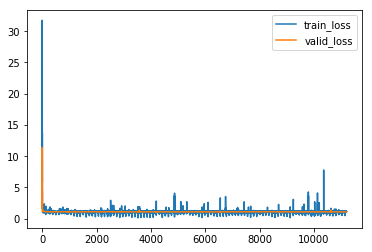

In [10]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='train_loss')
mplot.plot(valid_loss, label='valid_loss')
mplot.legend()
mplot.show()

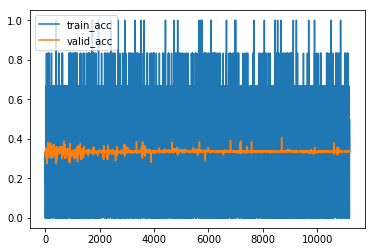

In [11]:
# import matplotlib.pyplot as mplot

mplot.plot(train_acc, label='train_acc')
mplot.plot(valid_acc, label='valid_acc')
mplot.legend()
mplot.show()